# Training and Testing by Experiments

We have the set of 1946 images form 16 experiments. Some of images are very similar. Usially, images from the same experiment have low variance. It means that we have "grouped data" and we want to be sure that the same group is not represented in both testing and training sets. 

http://scikit-learn.org/stable/modules/cross_validation.html#group-cv

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import sklearn
from sklearn import preprocessing
from sklearn import metrics
import seaborn as sns
import random

from os import listdir
from os.path import isfile, join

from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.calibration import CalibratedClassifierCV

import csv
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

import warnings
warnings.filterwarnings("ignore")

import yaml
from sklearn.model_selection import LeavePGroupsOut

In [2]:
df_work = pd.read_csv('labels_and_features_by_experiments.csv')
df_work.head(3)

experiment                      name  q_Imax  Imax_over_Imean  \
0         R1  R1_1stcool_0001_dz_bgsub    0.04        18.752705   
1         R1  R1_1stcool_0002_dz_bgsub    0.04        18.734222   
2         R1  R1_1stcool_0003_dz_bgsub    0.04        18.700700   

   Imax_sharpness  logI_fluctuation  logI_max_over_std  bad_data  form  \
0        1.039870          5.330748           3.075002     False  True   
1        1.038783          4.951954           3.026496     False  True   
2        1.038475          4.222822           3.196090     False  True   

   precursor  structure str_label  
0      False      False     form_  
1      False      False     form_  
2      False      False     form_

In [6]:
experiments = ['R1','R12','R13','R2','R3','R4','R5','R6','R7','Reaction_A','Reaction_B',
               'Reaction_C','Reaction_D','Reaction_E','Reaction_G','Reaction_H']

Let's compare some samples form the same experiment:

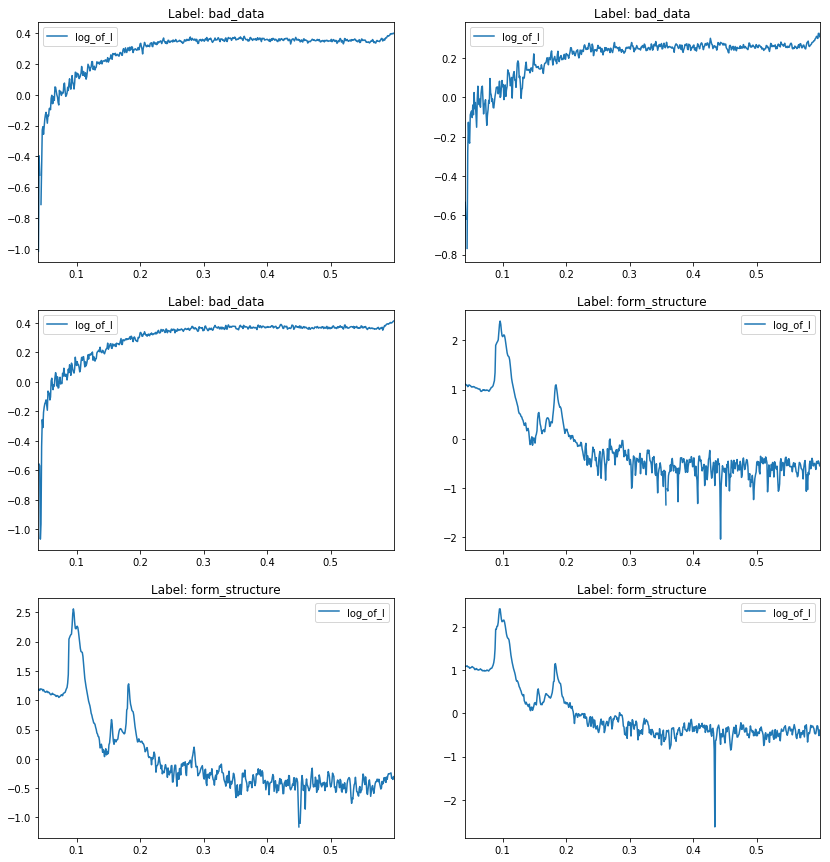

In [4]:
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(14,15))

for n in range(6): 
    d = df_work[df_work['experiment'] == 'R12']
    size_cl = len(d)
    r_n = random.randint(0,size_cl-1)
    file_name = d.iloc[r_n, 1]
    str_label = d.iloc[r_n, -1]
    df_v = pd.read_csv('../2016_saxs_data/R12/' + file_name + '.csv')
    df_v['log_of_I'] = np.log10(df_v[' Intensity (counts)'])
    df_v.plot(x='# q (1/Angstrom)',y='log_of_I', ax=axes[n%3, n%2])
    axes[n%3, n%2].set_title("Label: " + str_label);
    axes[n%3, n%2].xaxis.label.set_visible(False) 

Some samples are very similar.

### I will not use the images form the same experimnent in training and testing. 

Since we have few data, I am going to use cross validation by experiments. For example, to train the model on the experinent 1-13 and test on 14-16. Then train on 2-14 and test on 1, 15, and 16...

## Data Distribution: all data

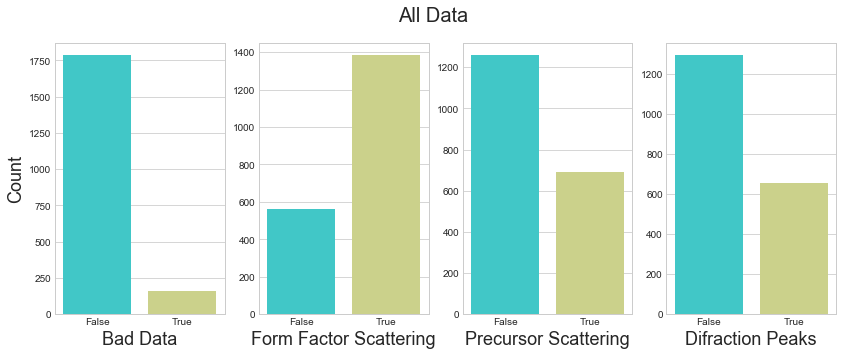

In [52]:
branches = ['bad_data', 'form', 'precursor', 'structure']
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(14,5))
st = fig.suptitle("All Data", fontsize=20)
for n in range(4): # max number of classes is 9, but we have only 6 now
    br = branches[n]
    sns.countplot(x=br, data=df_work, palette='rainbow', ax=axes[n])
    #axes[n].set_title("Label: " + br, fontsize=20);
axes[0].set_ylabel('Count', fontsize=18)
axes[1].yaxis.label.set_visible(False) 
axes[2].yaxis.label.set_visible(False) 
axes[3].yaxis.label.set_visible(False) 
axes[0].set_xlabel('Bad Data',fontsize=18)
axes[1].set_xlabel("Form Factor Scattering", fontsize=18);
axes[2].set_xlabel("Precursor Scattering", fontsize=18);
axes[3].set_xlabel("Difraction Peaks", fontsize=18);

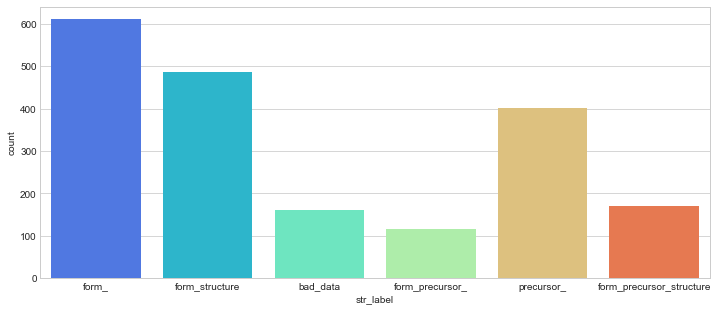

In [12]:
sns.set_style('whitegrid')
fig, axes = plt.subplots(figsize=(12,5))
sns.countplot(data=df_work, x='str_label',palette='rainbow')

## Data Distribution by Experiments

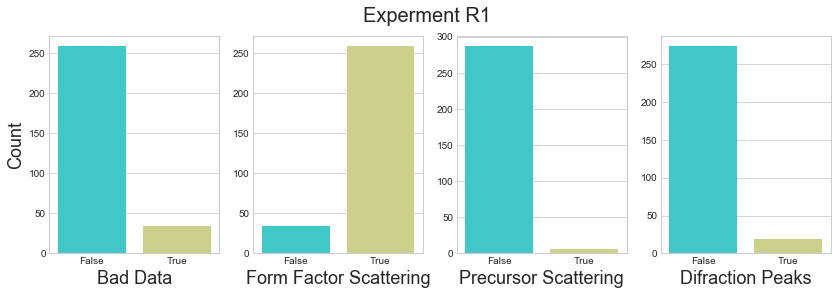

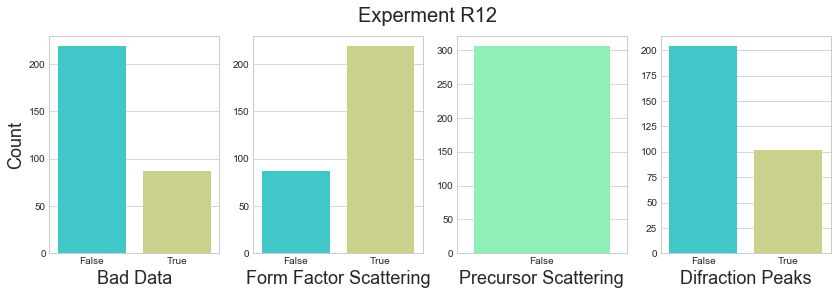

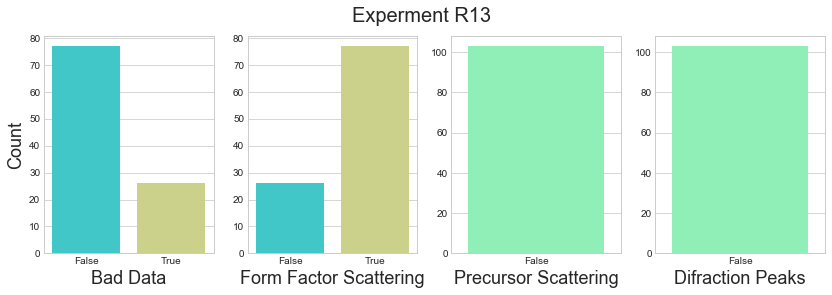

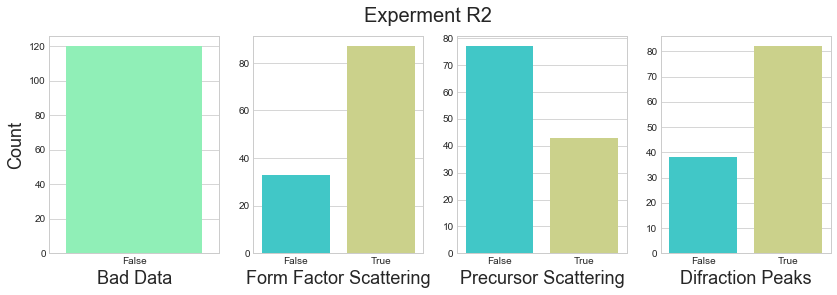

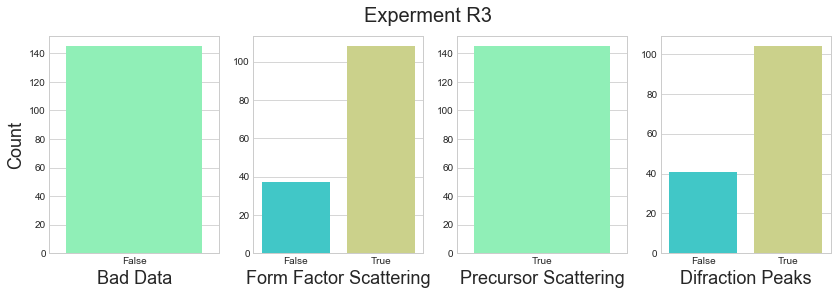

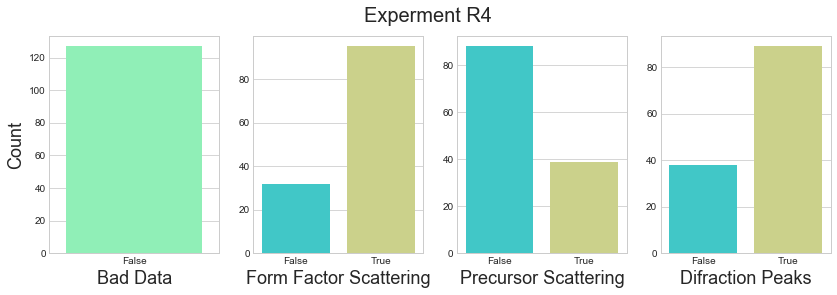

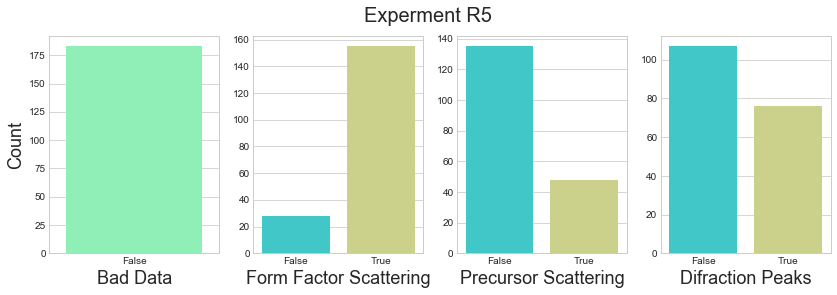

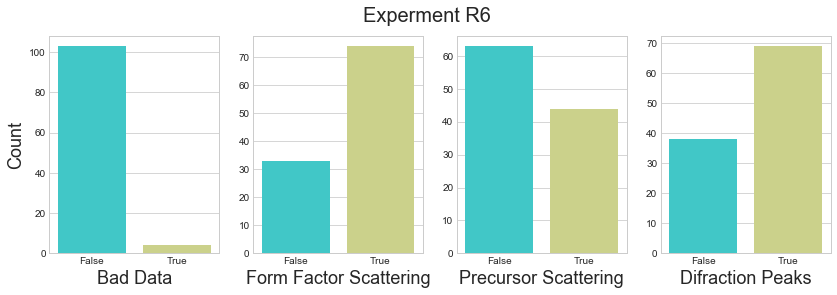

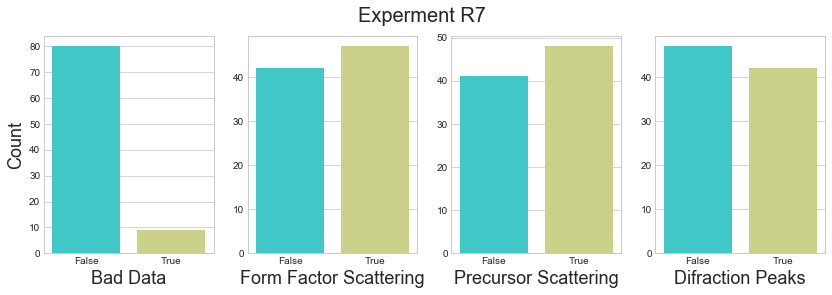

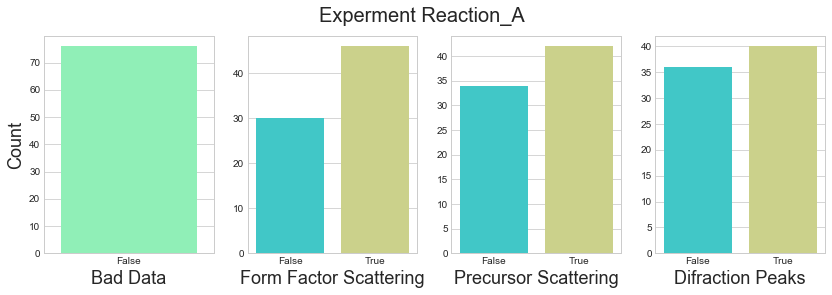

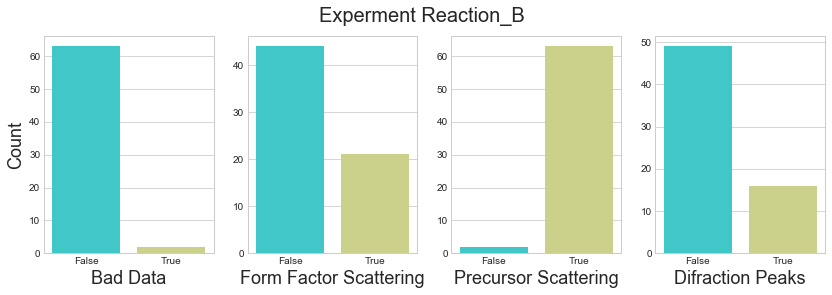

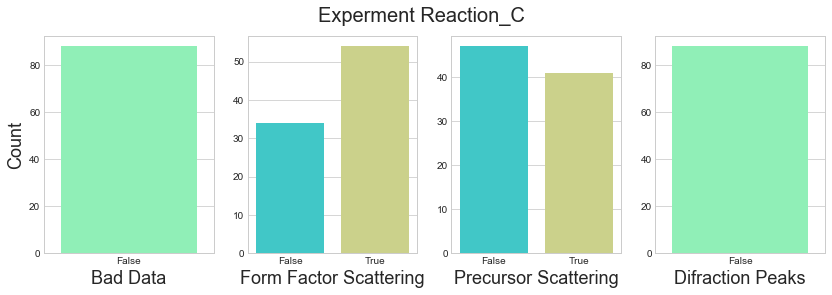

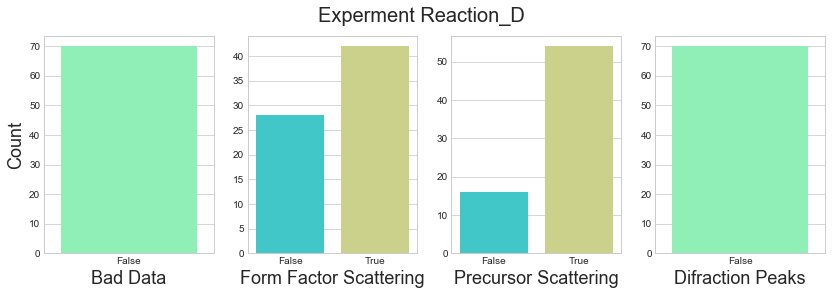

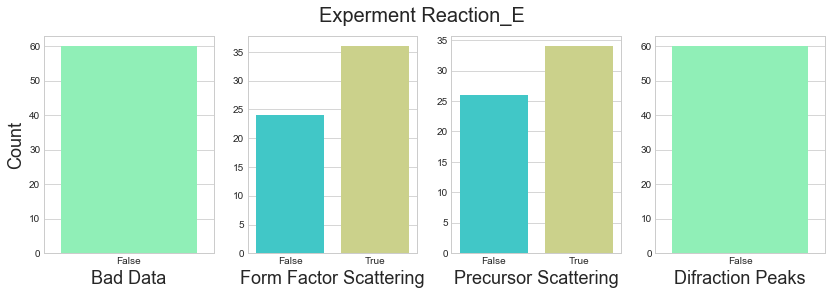

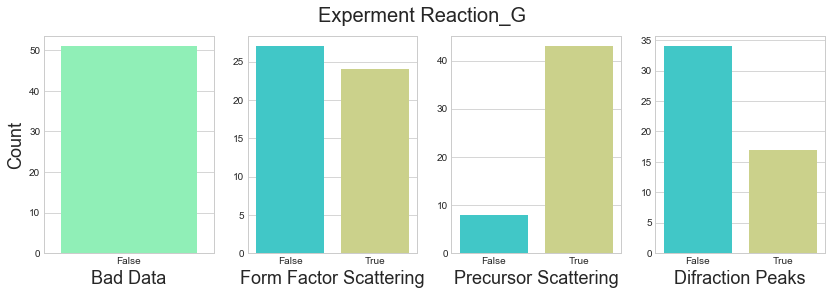

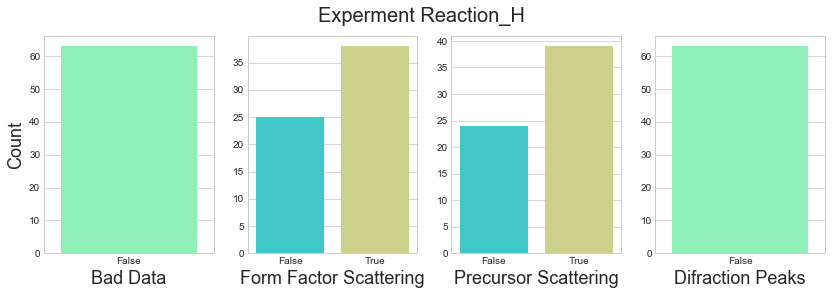

In [116]:
for expr in experiments:
    fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(14,4))
    st = fig.suptitle("Experment " + expr, fontsize=20)
    for n in range(4): # max number of classes is 9, but we have only 6 now
        br = branches[n]
        d = df_work[df_work['experiment'] == expr]
        sns.countplot(x=br, data=d, palette='rainbow', ax=axes[n])
    axes[0].set_ylabel('Count', fontsize=18)
    axes[1].yaxis.label.set_visible(False) 
    axes[2].yaxis.label.set_visible(False) 
    axes[3].yaxis.label.set_visible(False) 
    axes[0].set_xlabel('Bad Data',fontsize=18)
    axes[1].set_xlabel("Form Factor Scattering", fontsize=18);
    axes[2].set_xlabel("Precursor Scattering", fontsize=18);
    axes[3].set_xlabel("Difraction Peaks", fontsize=18);

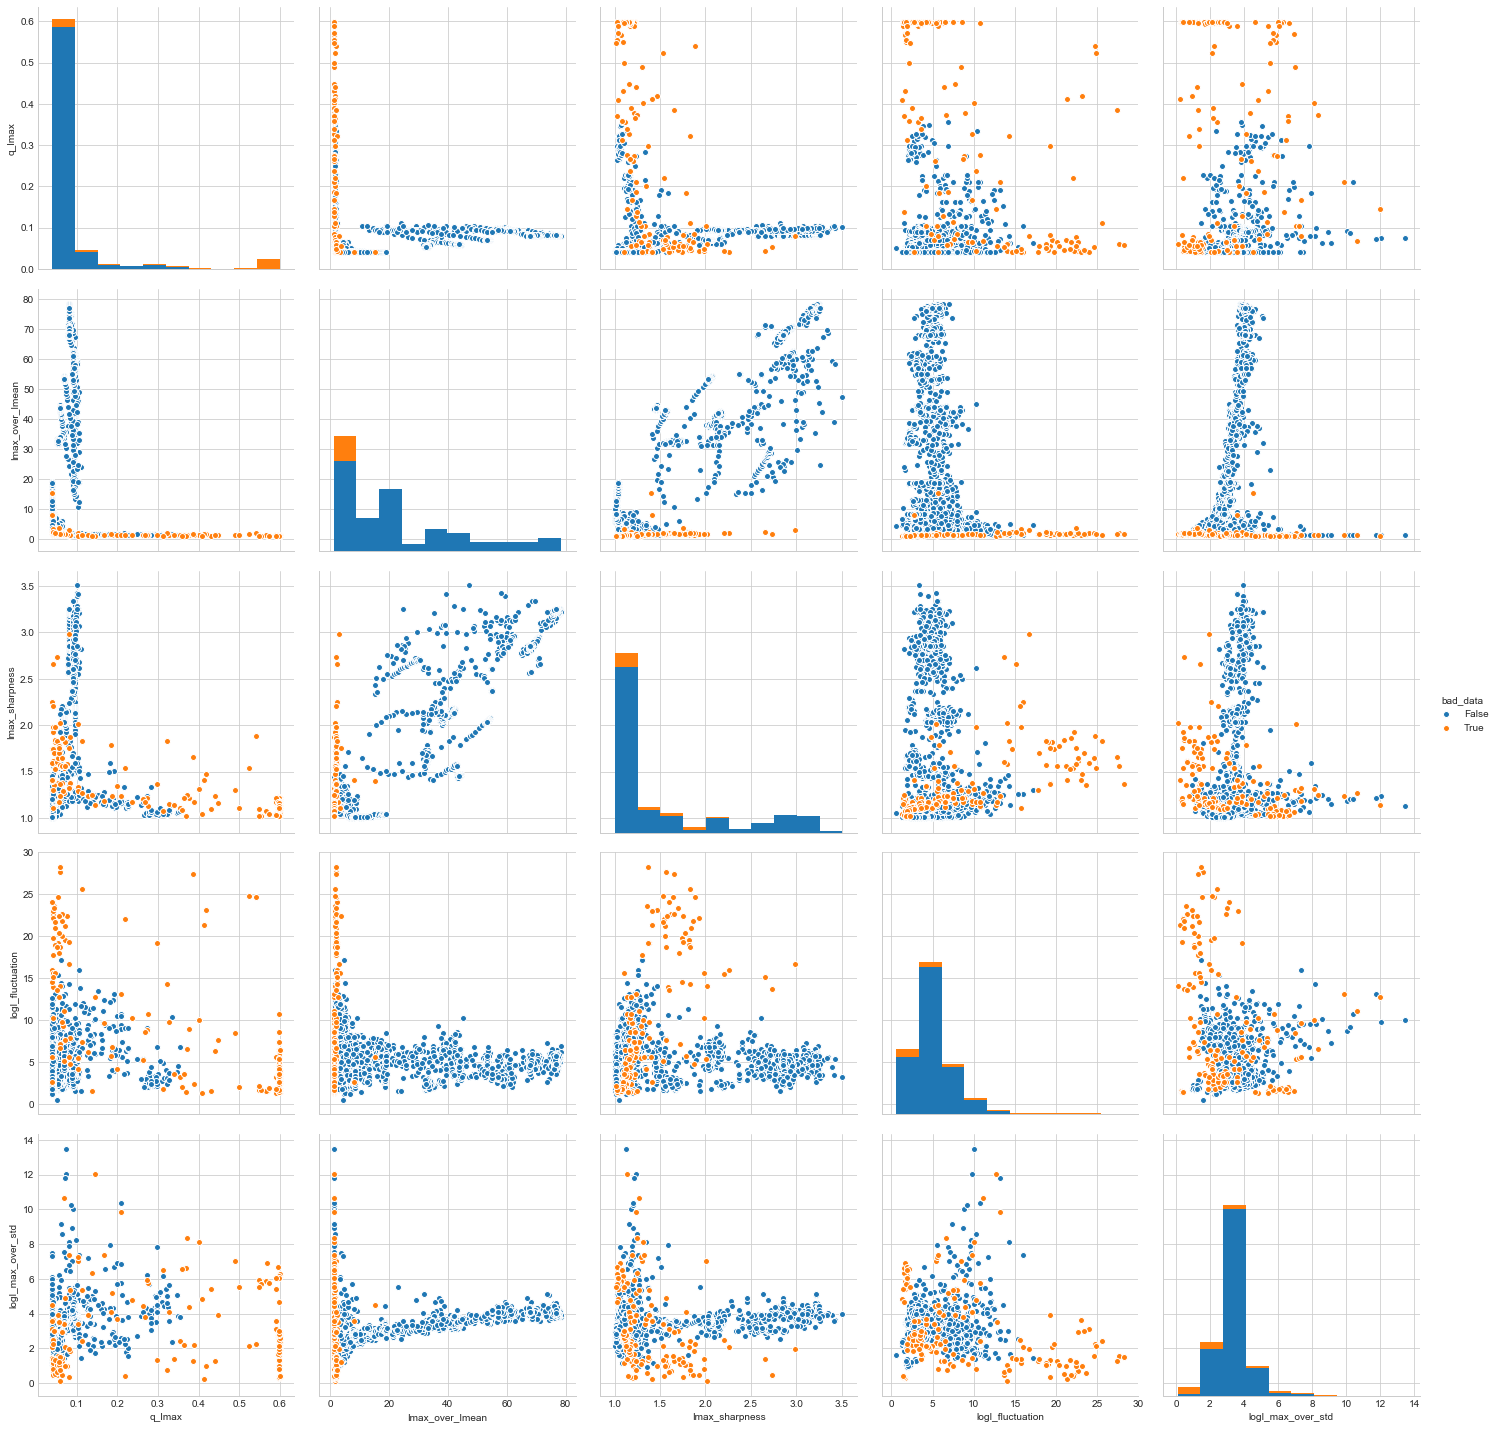

In [72]:
sns.pairplot(df_work[['q_Imax', 'Imax_over_Imean', 'Imax_sharpness',
       'logI_fluctuation', 'logI_max_over_std', 'bad_data']],size= 4, hue='bad_data', vars=['q_Imax', 'Imax_over_Imean', 'Imax_sharpness',
       'logI_fluctuation', 'logI_max_over_std'])

In [5]:
features = ['q_Imax', 'Imax_over_Imean', 'Imax_sharpness','logI_fluctuation', 'logI_max_over_std']

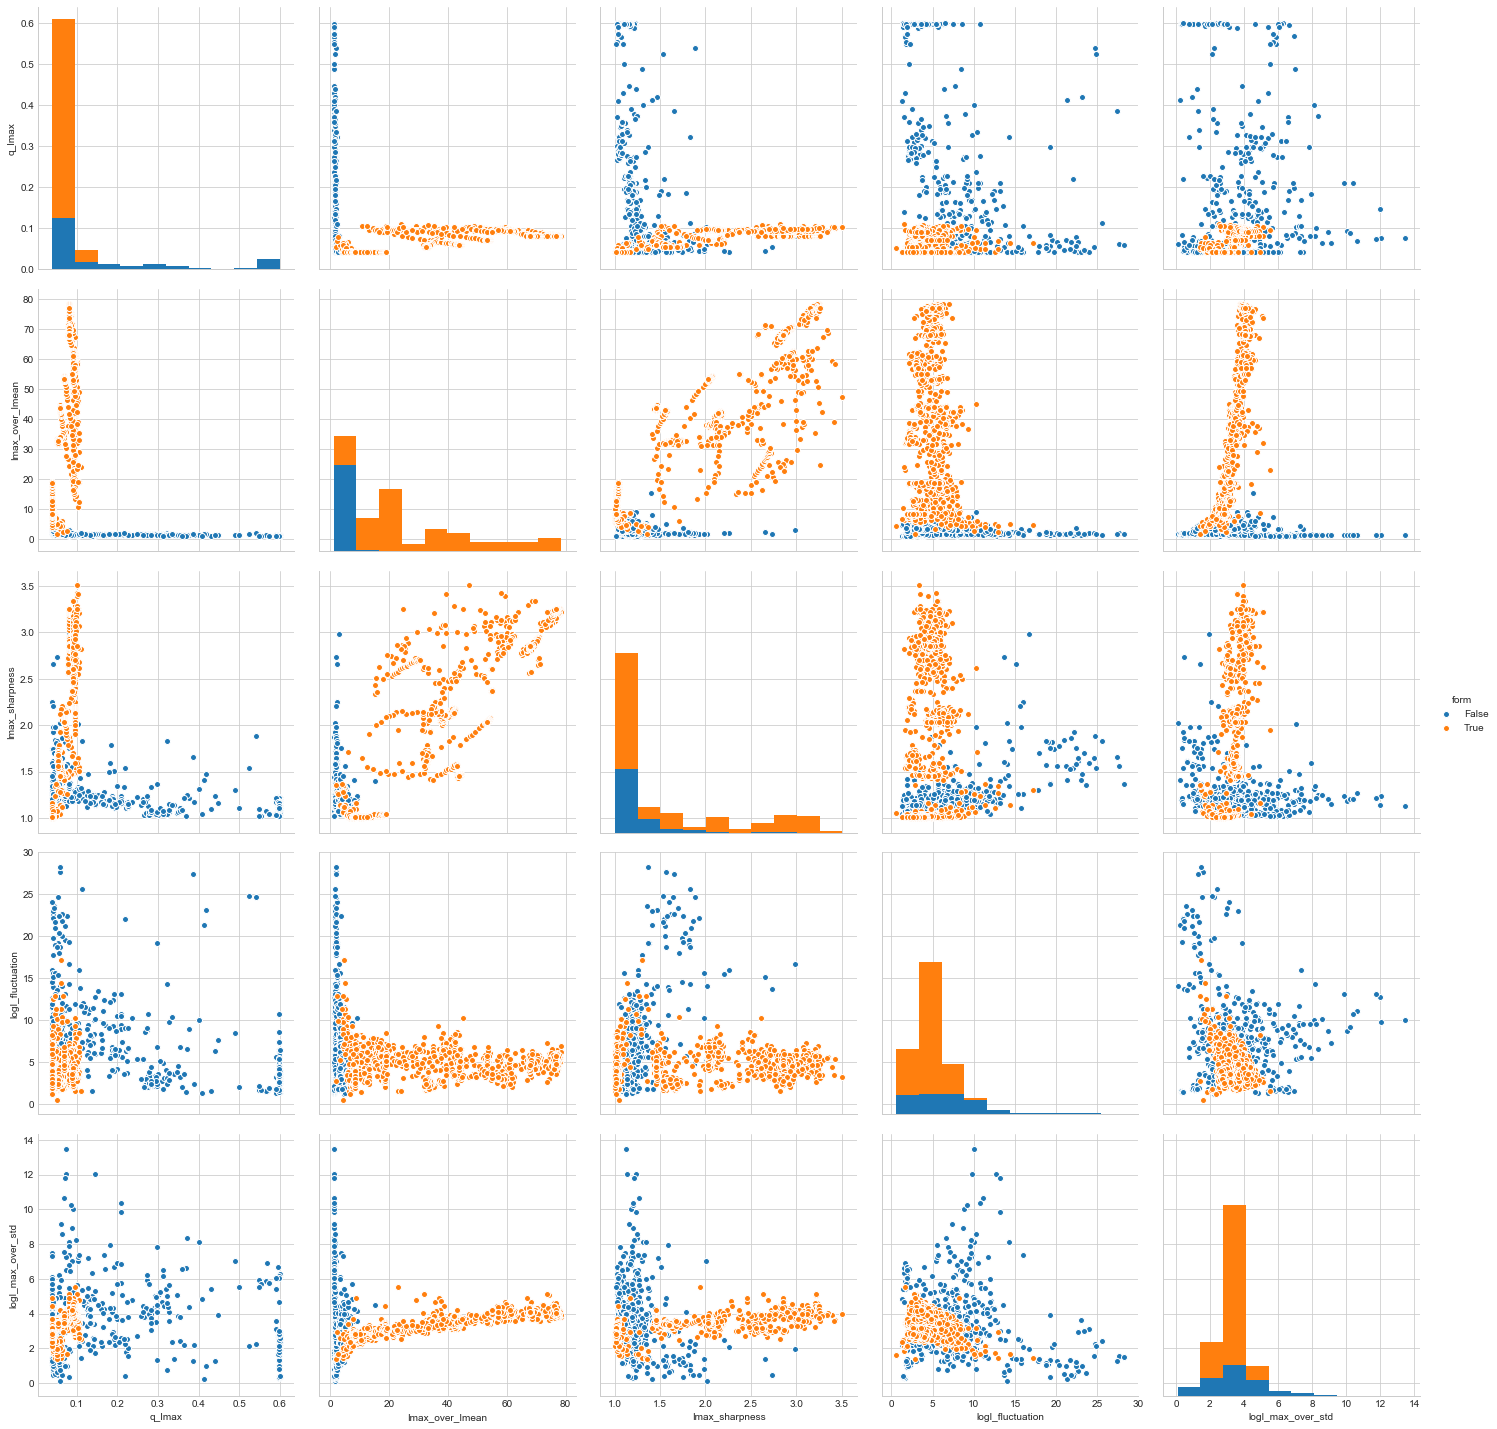

In [73]:
sns.pairplot(df_work[['q_Imax', 'Imax_over_Imean', 'Imax_sharpness',
       'logI_fluctuation', 'logI_max_over_std', 'form']],hue='form', size = 4, vars=['q_Imax', 'Imax_over_Imean', 'Imax_sharpness',
       'logI_fluctuation', 'logI_max_over_std'])

We can use only 2 features q_Imax and Imax_over_Imean for "form" label

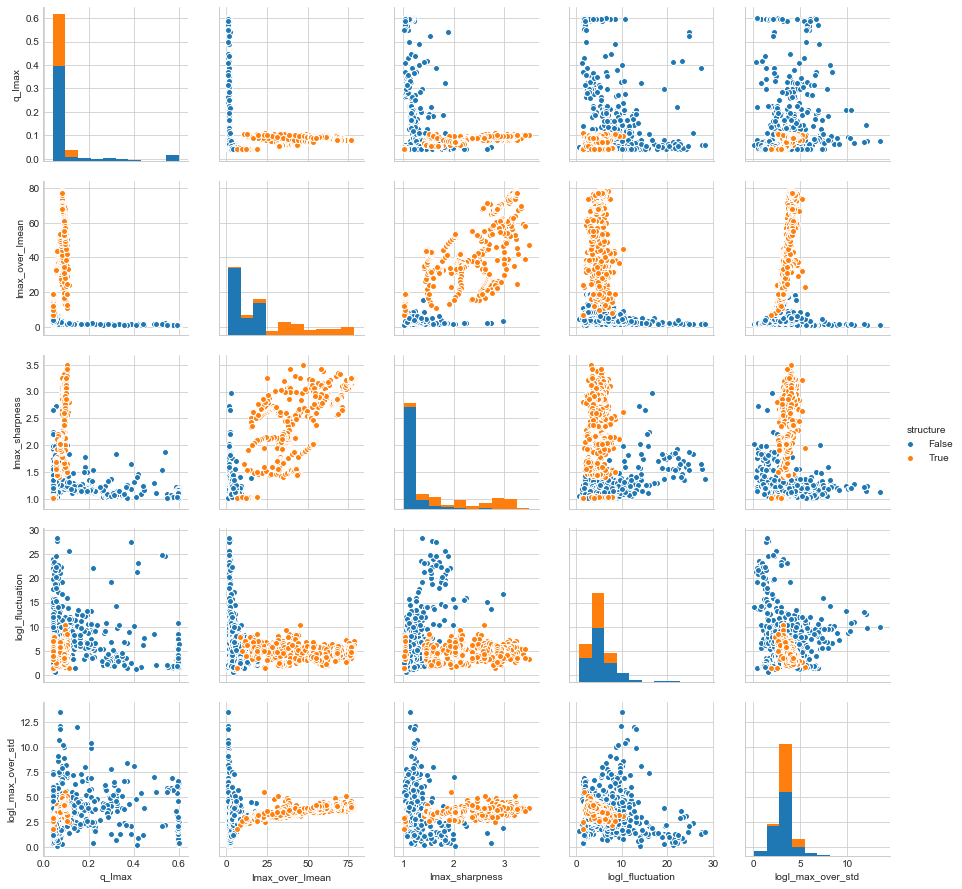

In [68]:
sns.pairplot(df_work[['q_Imax', 'Imax_over_Imean', 'Imax_sharpness',
       'logI_fluctuation', 'logI_max_over_std', 'structure']],hue='structure', vars=['q_Imax', 'Imax_over_Imean', 'Imax_sharpness',
       'logI_fluctuation', 'logI_max_over_std'])

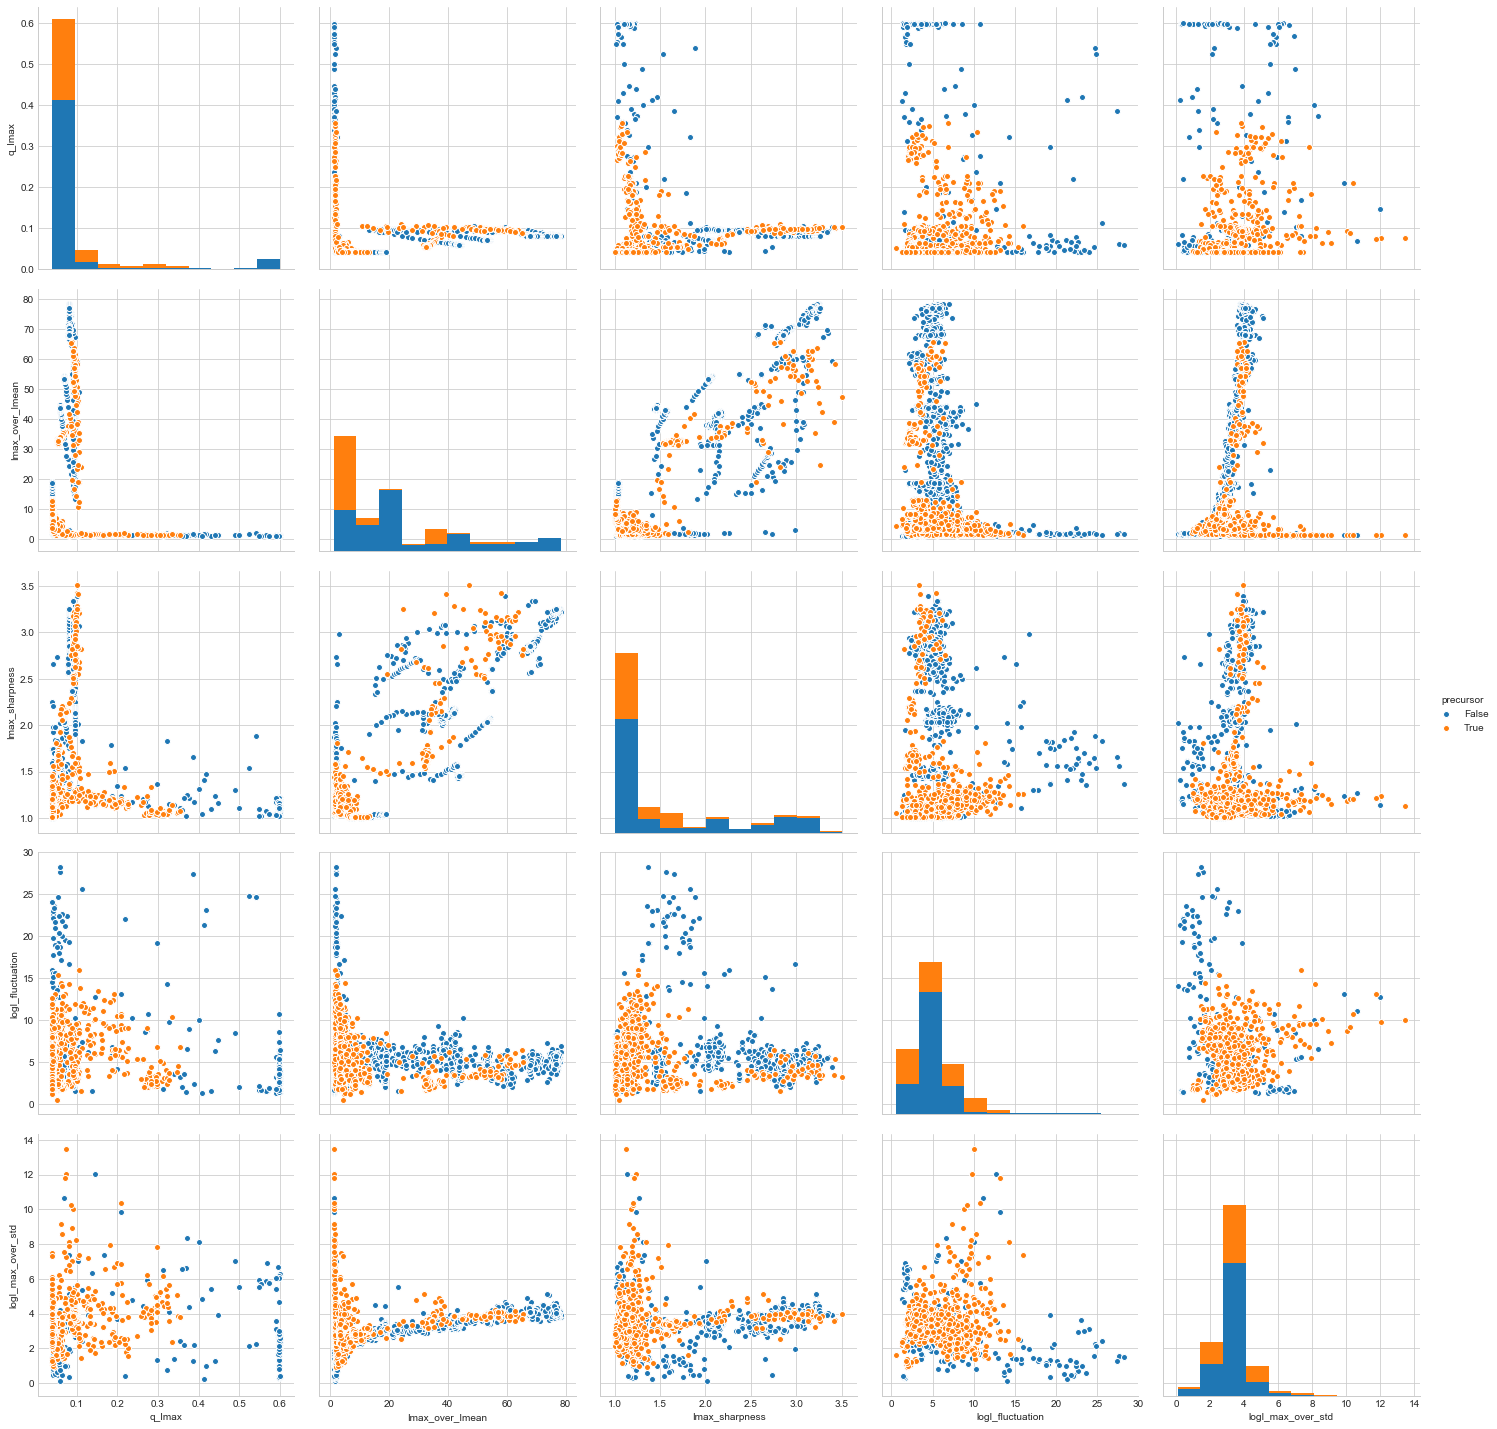

In [74]:
sns.pairplot(df_work[['q_Imax', 'Imax_over_Imean', 'Imax_sharpness',
       'logI_fluctuation', 'logI_max_over_std', 'precursor']],hue='precursor', vars=['q_Imax', 'Imax_over_Imean', 'Imax_sharpness',
       'logI_fluctuation', 'logI_max_over_std'], size=4)

The precursor is the hardest to separate! 

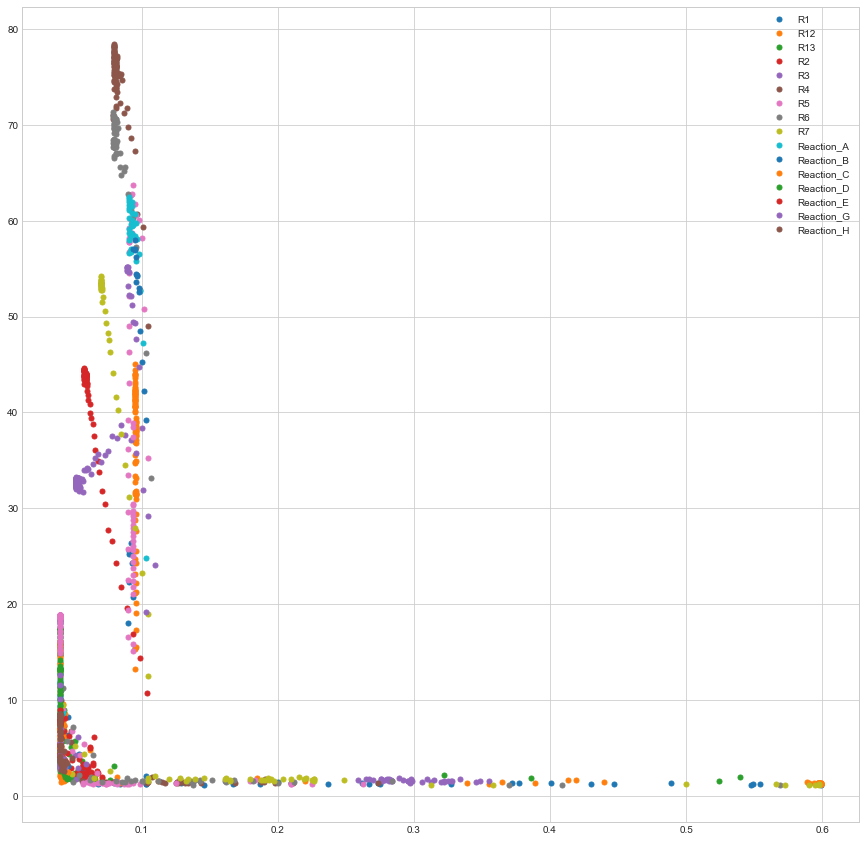

In [93]:
groups = df_work.groupby('experiment')

fig, ax = plt.subplots(figsize=(15,15))
ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling
for name, group in groups:
    ax.plot(group.q_Imax, group.Imax_over_Imean, marker='o', linestyle='', ms=5, label=name)
ax.legend()

plt.show()

In [67]:
shuffled_rows = np.random.permutation(df_work.index)
df_work = df_work.loc[shuffled_rows]

In [69]:
train = df_work.iloc[ : 1746]
hold_out = df_work.iloc[1746: ]

In [70]:
train.shape

(1746, 12)

In [71]:
hold_out.shape

(200, 12)

In [72]:
# I want to save the split and use it late for testing of unsupervised models
train.to_pickle('train_by_exp.pkl')
hold_out.to_pickle('hold_out_by_exp.pkl')

In [3]:
train = pd.read_pickle('train_by_exp.pkl')
hold_out = pd.read_pickle('hold_out_by_exp.pkl')

## Search for the best parametrs for the model

I decided to use SGDClassifier() since it has partial_fit() and it is possible to retrain the model using only new data.

This estimator implements regularized linear models with stochastic gradient descent learning: the gradient of the loss is estimated each sample at a time and the model is updated along the way with a decreasing learning rate. 

**Default configuration**:
SGDClassifier(loss=’hinge’, penalty=’l2’, alpha=0.0001, l1_ratio=0.15, fit_intercept=True, max_iter=None, tol=None, shuffle=True, verbose=0, epsilon=0.1, n_jobs=1, random_state=None, learning_rate=’optimal’, eta0=0.0, power_t=0.5, class_weight=None, warm_start=False, average=False, n_iter=None)

#### I will try some different values for the next parametrs: 

* **loss** changing this parametr we can get logistic regression, linear SVM, and perceptron
* **penalty**(regularization term): ‘none’, ‘l2’, ‘l1’, or ‘elasticnet.’ 
    * l2 (Ridge) is standart regularizer for SVM (alpha multiplyed on squares of weights)
    * l1 (LASSO) is the alpha multiplyed on the weights
    * elasticnet is a combination of Ridge and Lasso penalty: 
    \begin{equation*}
    (1 - l1 ratio) * \sum(W)^2 + l1 ratio * \sum|W|
    \end{equation*}
* **alpha** is a constant that multiplies the regularization term. It also is used to compute learning_rate when set to ‘optimal’
* **l1 ratio** is used only with elasticnet. Can be between 0 and 1.  l1_ratio=0 corresponds to L2 penalty, l1_ratio=1 to L1.
* **fit_intercept** If False, the data is assumed to be already centered.



I am using the default setting for max_iter and tol since they are good criteria for stopping (when loss > previous_loss - 1e-3 from 0.21). I am also using default "optimal" learning rate. In this case we do not need to specify a value since it is calculated by formula: 1.0 / (alpha * (t + t0)) where t0 is chosen by a heuristic proposed by Leon Bottou.

For best results the data should have zero mean and unit variance (we need to use a scaler).

**StandardScaler** "standardize features by removing the mean and scaling to unit variance
Centering and scaling happen independently on each feature by computing the relevant statistics on the samples in the training set. Mean and standard deviation are then stored to be used on later data using the transform method.
Standardization of a dataset is a common requirement for many machine learning estimators: they might behave badly if the individual feature do not more or less look like standard normally distributed data (e.g. Gaussian with 0 mean and unit variance).
For instance many elements used in the objective function of a learning algorithm (such as the RBF kernel of Support Vector Machines or the L1 and L2 regularizers of linear models) assume that all features are centered around 0 and have variance in the same order. If a feature has a variance that is orders of magnitude larger that others, it might dominate the objective function and make the estimator unable to learn from other features correctly as expected."
http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html

In [81]:
# parameters for SGDClassifier()
# loss= log    -> logistic regression
# loss = hinge -> linear SVM
# loss = perceptron -> perceptron
parameters = {'loss':('hinge', 'log', 'perceptron'), #default hinge
              'penalty':('none', 'l2', 'l1', 'elasticnet'), #default l2
              'alpha':[0.0001, 0.001, 0.01], #default 0.0001
             'l1_ratio': [0, 0.15, 0.5, 0.95], #default 0.15
             }

In [83]:
# only logistic regression
parameters2 = {'penalty':('none', 'l2', 'l1', 'elasticnet'), #default l2
              'alpha':[0.00001, 0.0001, 0.001, 0.01, 0.1], #regularisation koef, default 0.0001
             'l1_ratio': [0, 0.15, 0.5, 0.85, 1.0], #default 0.15
             }

## Bad Data

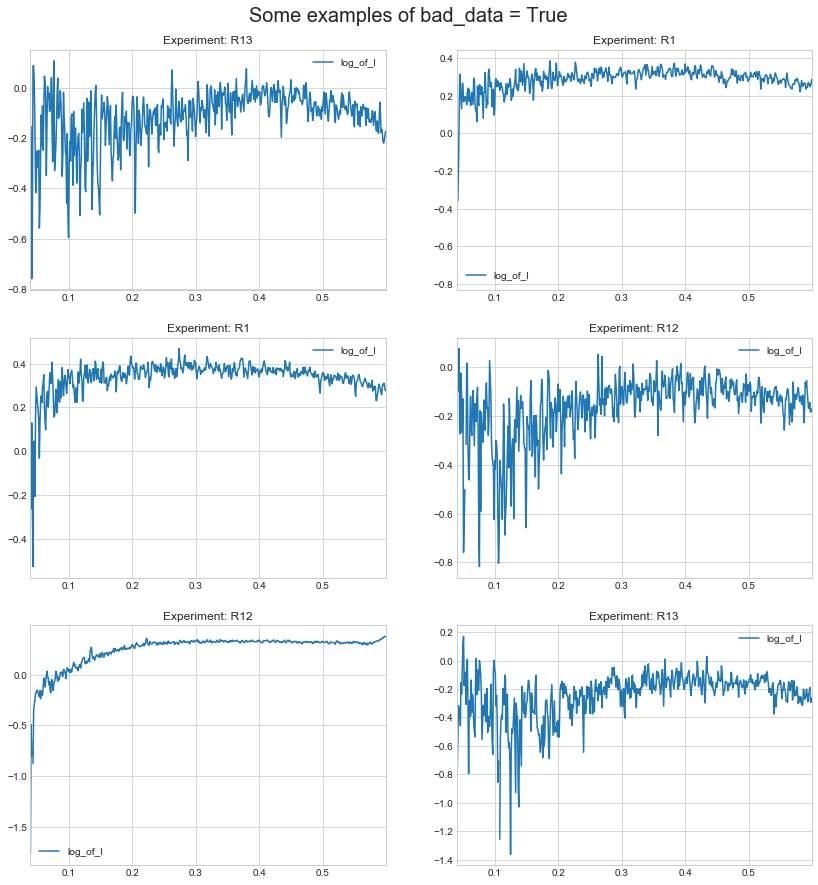

In [53]:
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(14,15))
st = fig.suptitle("Some examples of bad_data = True", fontsize=20)
st.set_y(0.92)
#fig.tight_layout()

for n in range(6): 
    d = train[train['bad_data'] == True]
    size_cl = len(d)
    r_n = random.randint(0,size_cl-1)
    file_name = d.iloc[r_n, 1]
    ex = d.iloc[r_n, 0]
    df_v = pd.read_csv('../2016_saxs_data/'+ ex + '/' + file_name + '.csv')
    df_v['log_of_I'] = np.log10(df_v[' Intensity (counts)'])
    df_v.plot(x='# q (1/Angstrom)',y='log_of_I', ax=axes[n%3, n%2])
    axes[n%3, n%2].set_title("Experiment: " + ex);
    axes[n%3, n%2].xaxis.label.set_visible(False)  

### Using GridSearchCV() for choosing the best parametrs and best feature set for "bad_data" labels:

In [96]:
# cross validation "two goup out" - we train the model on 14 groups and test on 2 groups
cv=LeavePGroupsOut(n_groups=2).split(train[features], train[['bad_data']], groups=train['experiment'])

In [84]:
scaler = preprocessing.StandardScaler()
scaler.fit(train[features])
svc = linear_model.SGDClassifier(loss = 'log')
clf = GridSearchCV(svc, parameters2, cv=cv)
    
clf.fit(scaler.transform(train[features]), train['bad_data'])
print("Best parameters set found on training set:")
print(clf.best_params_)
    
print("Training score: ","%0.3f" %  clf.best_score_)#Cross-validated score on training set

Best parameters set found on training set:
{'alpha': 0.001, 'l1_ratio': 1.0, 'penalty': 'l1'}
Training score:  0.978


**Let's check how this model works for different experiments**

In [7]:
test_scores_by_ex = []
training_score = []
stat_dic = {}
count = 0 # we have 120 combinations
for i in range(len(experiments)):
    for j in range(i +1, len(experiments)):
        print("Testing on: ", experiments[i], 'and', experiments[j])
        tr = train[(train['experiment']!= experiments[i]) & (train['experiment']!= experiments[j])]
        test = train[(train['experiment']== experiments[i]) | (train['experiment']== experiments[j])]
        
        scaler = preprocessing.StandardScaler()
        scaler.fit(tr[features])
        log = linear_model.SGDClassifier(alpha= 0.001,loss= 'log', l1_ratio= 0.95, penalty= 'elasticnet')

        scores = cross_val_score(log, scaler.transform(tr[features]), tr['bad_data'], cv=5)
        print("cross validation score: ", scores.mean())
        training_score.append(scores.mean())
        stat_dic[experiments[i]+ experiments[j]] = scores.mean()

        log.fit(scaler.transform(tr[features]), tr['bad_data'])
        test_score = log.score(scaler.transform(test[features]), test['bad_data'])
        print('test score: ', test_score)
        test_scores_by_ex.append(test_score)
        stat_dic[experiments[i]+ experiments[j]] = test_score
        count +=1
        print()
        
print("Average training score: ", sum(training_score)/count)
print("Average testing score: ", sum(test_scores_by_ex)/count)
print(count)

Testing on:  R1 and R12
cross validation score:  0.990024147549
test score:  0.935424354244

Testing on:  R1 and R13
cross validation score:  0.987767038029
test score:  0.93837535014

Testing on:  R1 and R2
cross validation score:  0.987625669581
test score:  0.943699731903

Testing on:  R1 and R3
cross validation score:  0.984490811085
test score:  0.94387755102

Testing on:  R1 and R4
cross validation score:  0.986131289635
test score:  0.949468085106

Testing on:  R1 and R5
cross validation score:  0.983223521899
test score:  0.951724137931

Testing on:  R1 and R6
cross validation score:  0.989907204671
test score:  0.935754189944

Testing on:  R1 and R7
cross validation score:  0.987887592078
test score:  0.906432748538

Testing on:  R1 and Reaction_A
cross validation score:  0.986574855998
test score:  0.936555891239

Testing on:  R1 and Reaction_B
cross validation score:  0.98665184087
test score:  0.934782608696

Testing on:  R1 and Reaction_C
cross validation score:  0.9864793

Testing on:  R6 and Reaction_C
cross validation score:  0.980291097008
test score:  0.936416184971

Testing on:  R6 and Reaction_D
cross validation score:  0.978604274003
test score:  0.987261146497

Testing on:  R6 and Reaction_E
cross validation score:  0.978134637545
test score:  0.986206896552

Testing on:  R6 and Reaction_G
cross validation score:  0.975170555401
test score:  0.963235294118

Testing on:  R6 and Reaction_H
cross validation score:  0.976210815047
test score:  0.959731543624

Testing on:  R7 and Reaction_A
cross validation score:  0.978113171271
test score:  0.993197278912

Testing on:  R7 and Reaction_B
cross validation score:  0.975131987578
test score:  0.985507246377

Testing on:  R7 and Reaction_C
cross validation score:  0.976717581062
test score:  0.923566878981

Testing on:  R7 and Reaction_D
cross validation score:  0.978814191869
test score:  0.985815602837

Testing on:  R7 and Reaction_E
cross validation score:  0.977108835437
test score:  0.984496124031



In [8]:
for w in sorted(stat_dic, key=stat_dic.get):
    print(w, stat_dic[w])

R6R7 0.867816091954
R1R7 0.906432748538
R12R13 0.911528150134
R4R6 0.918269230769
R7Reaction_C 0.923566878981
R1Reaction_G 0.930921052632
R1Reaction_E 0.932907348243
R1Reaction_H 0.933753943218
R1Reaction_B 0.934782608696
R1Reaction_D 0.935384615385
R1R12 0.935424354244
R1R6 0.935754189944
R13R5 0.936090225564
R6Reaction_C 0.936416184971
R1Reaction_A 0.936555891239
R1R13 0.93837535014
R1Reaction_C 0.938416422287
R3Reaction_D 0.942408376963
R12R3 0.94362745098
R1R2 0.943699731903
R1R3 0.94387755102
R3R7 0.947115384615
R12Reaction_E 0.948328267477
R1R4 0.949468085106
R1R5 0.951724137931
R12R4 0.954081632653
R6Reaction_A 0.957055214724
R12R6 0.957219251337
R12Reaction_H 0.957957957958
R12Reaction_B 0.958579881657
R12Reaction_A 0.959654178674
R6Reaction_H 0.959731543624
R3R6 0.959821428571
R12Reaction_C 0.960784313725
R12R7 0.960893854749
R6Reaction_B 0.961038961039
R4R5 0.961403508772
R12Reaction_D 0.961876832845
R12Reaction_G 0.9625
R5R6 0.962546816479
R13R6 0.962962962963
R6Reaction_G 0

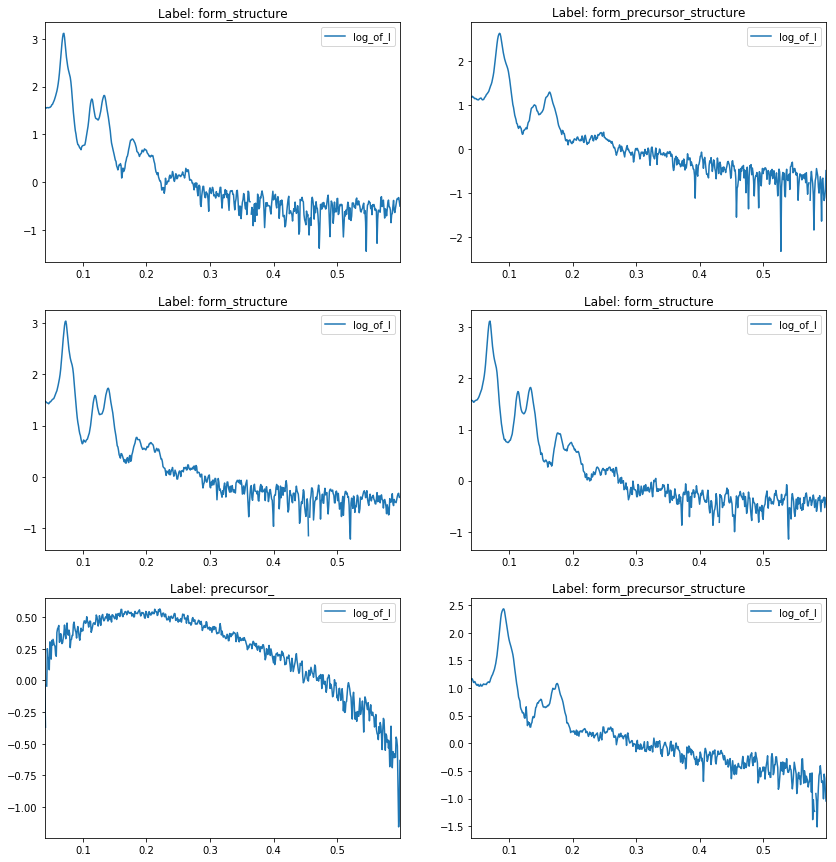

In [10]:
#  R7
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(14,15))

for n in range(6): 
    d = df_work[df_work['experiment'] == 'R7']
    size_cl = len(d)
    r_n = random.randint(0,size_cl-1)
    file_name = d.iloc[r_n, 1]
    str_label = d.iloc[r_n, -1]
    df_v = pd.read_csv('../2016_saxs_data/R7/' + file_name + '.csv')
    df_v['log_of_I'] = np.log10(df_v[' Intensity (counts)'])
    df_v.plot(x='# q (1/Angstrom)',y='log_of_I', ax=axes[n%3, n%2])
    axes[n%3, n%2].set_title("Label: " + str_label);
    axes[n%3, n%2].xaxis.label.set_visible(False) 


In [12]:
d = df_work[(df_work['experiment'] == 'R7') & (df_work['bad_data'] == True)]
d

experiment                   name  q_Imax  Imax_over_Imean  \
1384         R7  R7_cool_0001_dz_bgsub   0.500         1.284072   
1385         R7  R7_cool_0002_dz_bgsub   0.598         1.228205   
1386         R7  R7_cool_0003_dz_bgsub   0.566         1.243392   
1387         R7  R7_cool_0004_dz_bgsub   0.595         1.181861   
1388         R7  R7_cool_0005_dz_bgsub   0.598         1.174245   
1389         R7  R7_cool_0006_dz_bgsub   0.573         1.169726   
1390         R7  R7_cool_0007_dz_bgsub   0.358         1.174369   
1391         R7  R7_cool_0008_dz_bgsub   0.313         1.161711   
1392         R7  R7_cool_0009_dz_bgsub   0.590         1.136828   

      Imax_sharpness  logI_fluctuation  logI_max_over_std  bad_data   form  \
1384        1.107021          2.085838           5.552313      True  False   
1385        1.031128          1.463673           4.660290      True  False   
1386        1.075519          1.646728           5.900980      True  False   
1387        1.028945          1.947021           6.658272      True  False   
1388        1.024779          1.742926           6.021404      True  False   
1389        1.039373          1.934516           5.732932      True  False   
1390        1.086194          2.083032           6.566644      True  False   
1391        1.081358          1.867558           6.495162      True  False   
1392        1.032931          1.876202           6.071103      True  False   

      precursor  structure str_label  
1384      False      False  bad_data  
1385      False      False  bad_data  
1386      False      False  bad_data  
1387      False      False  bad_data  
1388      False      False  bad_data  
1389      False      False  bad_data  
1390      False      False  bad_data  
1391      False      False  bad_data  
1392      False      False  bad_data

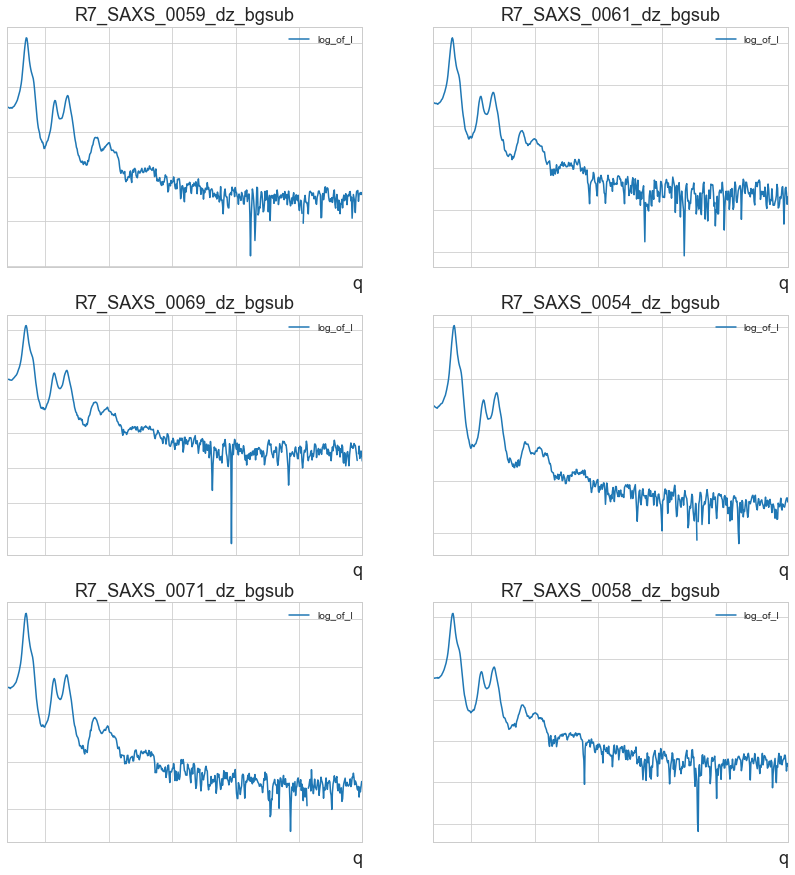

In [29]:
# Form Structure in R7
sns.set_style('whitegrid')
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(14,15))

for n in range(6): 
    d = df_work[(df_work['experiment'] == 'R7') & (df_work['str_label'] == 'form_structure')]
    size_cl = len(d)
    r_n = random.randint(0,size_cl-1)
    file_name = d.iloc[r_n, 1]
    str_label = d.iloc[r_n, -1]
    df_v = pd.read_csv('../2016_saxs_data/R7/' + file_name + '.csv')
    df_v['log_of_I'] = np.log10(df_v[' Intensity (counts)'])
    df_v.plot(x='# q (1/Angstrom)',y='log_of_I', ax=axes[n%3, n%2])
    axes[n%3, n%2].set_title(file_name, fontsize=18);
    axes[n%3, n%2].set_yticklabels([])
    axes[n%3, n%2].set_xticklabels([])
    axes[n%3, n%2].set_xlabel('q', fontsize=18,  horizontalalignment='right', x=1.0)

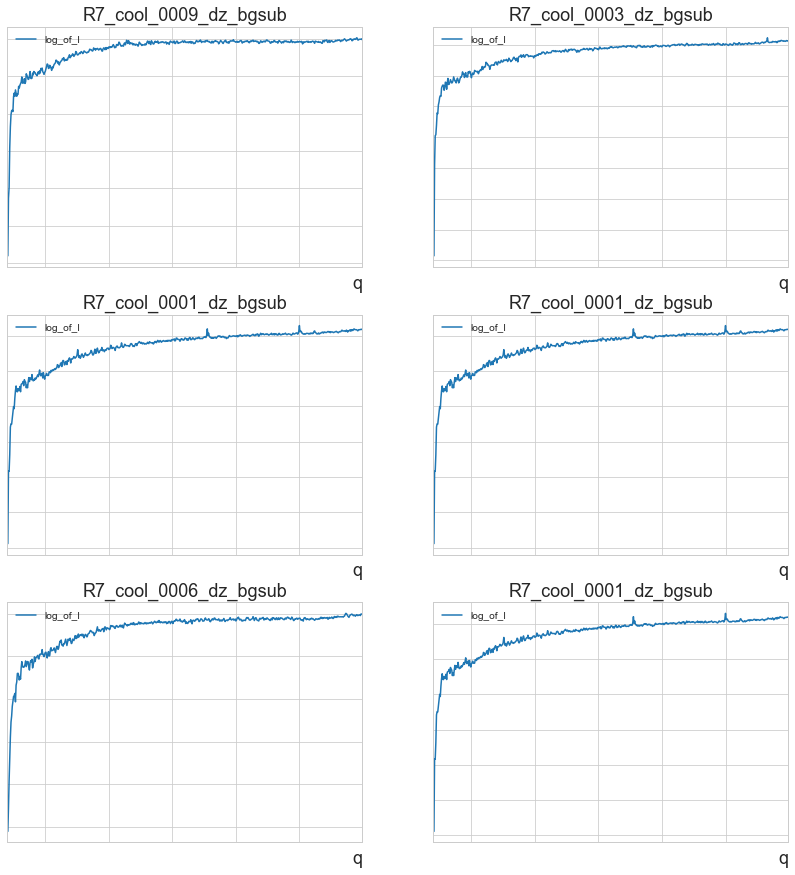

In [24]:
# bad data in R7
sns.set_style('whitegrid')
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(14,15))

for n in range(6): 
    d = df_work[(df_work['experiment'] == 'R7') & (df_work['bad_data'] == True)]
    size_cl = len(d)
    r_n = random.randint(0,size_cl-1)
    file_name = d.iloc[r_n, 1]
    str_label = d.iloc[r_n, -1]
    df_v = pd.read_csv('../2016_saxs_data/R7/' + file_name + '.csv')
    df_v['log_of_I'] = np.log10(df_v[' Intensity (counts)'])
    df_v.plot(x='# q (1/Angstrom)',y='log_of_I', ax=axes[n%3, n%2])
    axes[n%3, n%2].set_title(file_name, fontsize=18);
    axes[n%3, n%2].set_yticklabels([])
    axes[n%3, n%2].set_xticklabels([])
    axes[n%3, n%2].set_xlabel('q', fontsize=18,  horizontalalignment='right', x=1.0)
    #axes[n%3, n%2].set_ylabel('log I', fontsize=18,  horizontalalignment='right', y=0.9, rotation=0)

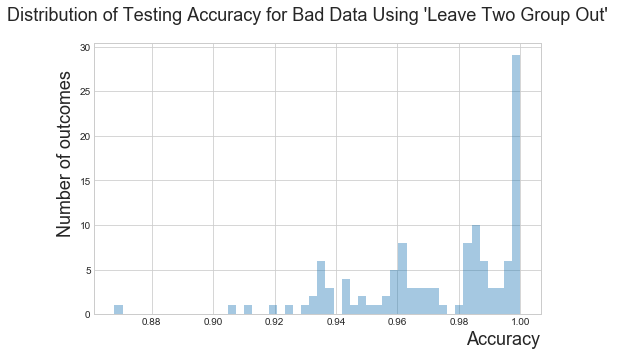

In [38]:
plt.figure(figsize=(8,5))
sns.distplot(test_scores_by_ex, kde=False, bins=50)
plt.suptitle("Distribution of Testing Accuracy for Bad Data Using 'Leave Two Group Out' ", fontsize=18)
#plt.suptitle("Bad Data", fontsize=20)
plt.xlabel('Accuracy', fontsize=18,  horizontalalignment='right', x=1.0)
plt.ylabel('Number of outcomes', fontsize=18, horizontalalignment='right', y=0.9)

In [159]:
# we need to save the version of sklearn to use in PAWS
current_version = list(map(int,sklearn.__version__.split('.')))
major,minor,patch = current_version
current_version

[0, 19, 0]

In [160]:
# I am saving version of sklearn with all scalers and models. 
# Then I will dump them into a yaml file that will be used in PAWS app.
scalers = {} 
models = {}
scalers_and_models = {'version':current_version, 'scalers' : scalers, 'models': models}

In [41]:
scaler = preprocessing.StandardScaler()
scaler.fit(train[features])
log = linear_model.SGDClassifier(alpha= 0.001,loss= 'log', l1_ratio= 0.95, penalty= 'elasticnet')

#train the model on all training data and test on "hold out" data
log.fit(scaler.transform(train[features]), train['bad_data'])
hold_out_score = log.score(scaler.transform(hold_out[features]), hold_out['bad_data'])
print("hold out score: ", hold_out_score)

hold out score:  0.975


In [42]:
hold_out['bad_data_pred'] = log.predict(scaler.transform(hold_out[features]))

pr = log.predict_proba(scaler.transform(hold_out[features]))[ : , 1]
formated_pr = list(map(lambda x: "{0:.5f}".format(x), pr))

hold_out['bad_data_prob_true'] =  pd.to_numeric(formated_pr)

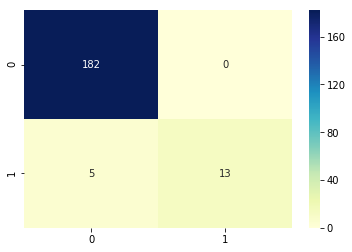

In [13]:
cnf_matrix = confusion_matrix(hold_out['bad_data'], hold_out['bad_data_pred'])
sns.heatmap(cnf_matrix, annot=True, fmt='.5g', cmap="YlGnBu")

**We have 5 false negative.**

In [175]:
difference = hold_out[hold_out['bad_data'] != hold_out['bad_data_pred']]
difference[['experiment','name', 'str_label','bad_data','bad_data_pred', 'bad_data_prob_true']]

experiment                         name str_label  bad_data  \
233          R1        R1_reac_0026_dz_bgsub  bad_data      True   
212          R1        R1_reac_0005_dz_bgsub  bad_data      True   
1391         R7        R7_cool_0008_dz_bgsub  bad_data      True   
209          R1        R1_reac_0002_dz_bgsub  bad_data      True   
462         R12  R12cooling2rd_0055_dz_bgsub  bad_data      True   
1380         R6        R6_SAXS_0001_dz_bgsub  bad_data      True   

      bad_data_pred  bad_data_prob_true  
233           False             0.04611  
212           False             0.12408  
1391          False             0.15647  
209           False             0.45158  
462           False             0.00034  
1380          False             0.01978

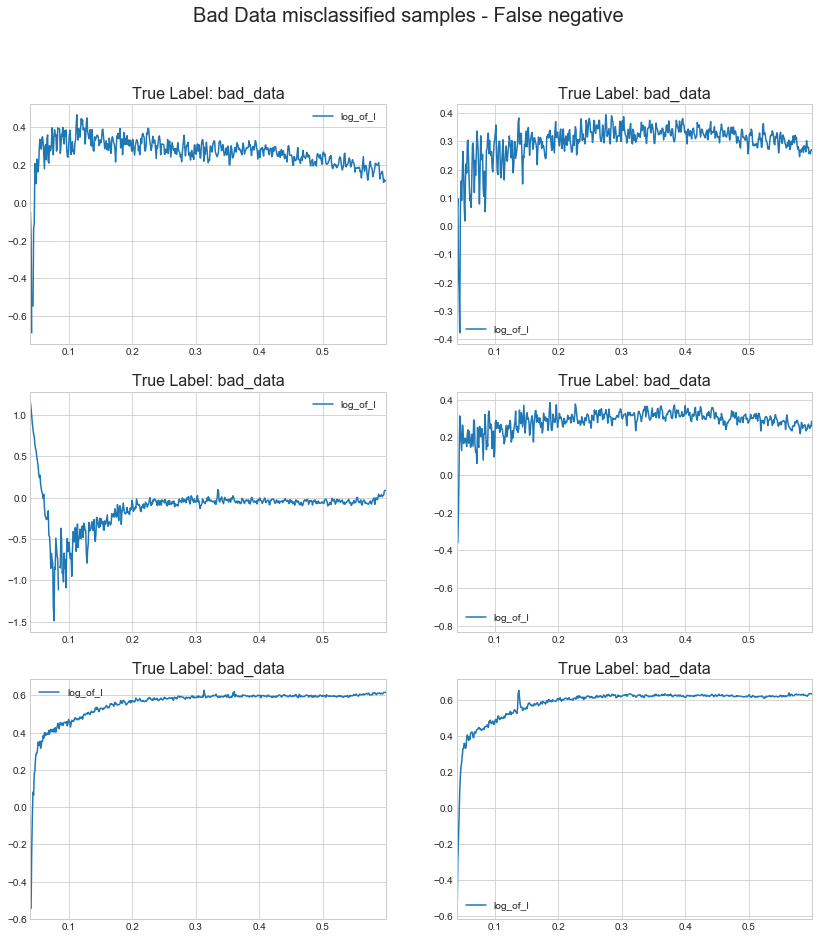

In [176]:
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(14,15))
st = fig.suptitle("Bad Data misclassified samples - False negative", fontsize=20)
st.set_y(0.97)

for n in range(len(difference)): 
    d = difference.iloc[n]
    ex = d.iloc[0]
    file_name = d.iloc[1]
    str_label = difference.iloc[n]['str_label']
    df_v = pd.read_csv('../2016_saxs_data/' + ex + '/' + file_name + '.csv')
    df_v['log_of_I'] = np.log10(df_v[' Intensity (counts)'])
    df_v.plot(x='# q (1/Angstrom)',y='log_of_I', ax=axes[n%3, n%2])
    axes[n%3, n%2].set_title('True Label: ' + str_label, fontsize=16);
    axes[n%3, n%2].xaxis.label.set_visible(False)

In [177]:
# to train the model on all avalible data 
all_data = train.append(hold_out)
scaler = preprocessing.StandardScaler()
scaler.fit(all_data[features])
log = linear_model.SGDClassifier(alpha= 0.001,loss= 'log', l1_ratio= 0.95, penalty= 'elasticnet')
log.fit(scaler.transform(all_data[features]), all_data['bad_data'])

# save the scaler and model
scalers['bad_data'] = scaler.__dict__
models['bad_data'] = log.__dict__

### Now we will use only samples that have label "bad_data" : False

In [43]:
#now we need only "good" data
train_good = train[train['bad_data']==False]
train_good.shape

(1602, 12)

In [44]:
test_good = hold_out[hold_out['bad_data_pred']==False]
test_good.shape

(187, 14)

## Form Label
### I am using GridSearchCV() again for choosing the best parametrs and best feature set for "form" labels. 

Since Logistic Regression has partial_fit() and predict_prop() I will try to get a good result using only logistic Regression.

In [45]:
cv=LeavePGroupsOut(n_groups=2).split(train_good[features], train_good[['form']], groups=train_good['experiment'])

In [181]:
scaler = preprocessing.StandardScaler()
scaler.fit(train_good[features])
svc = linear_model.SGDClassifier(loss = 'log') # we want to use log regression only
clf = GridSearchCV(svc, parameters2, cv=cv)
    
clf.fit(scaler.transform(train_good[features]), train_good['form'])
print("Best parameters set found on training set:")
print(clf.best_params_)
    
print("Training score: ","%0.3f" %  clf.best_score_)#Cross-validated score on training set

Best parameters set found on training set:
{'alpha': 0.0001, 'l1_ratio': 0.5, 'penalty': 'l1'}
Training score:  0.983


In [46]:
test_scores_by_ex = []
training_score = []
count = 0 # we have 120 combinations
for i in range(len(experiments)):
    for j in range(i +1, len(experiments)):
        print("Testing on: ", experiments[i], 'and', experiments[j])
        tr = train_good[(train_good['experiment']!= experiments[i]) & (train_good['experiment']!= experiments[j])]
        test = train_good[(train['experiment']== experiments[i]) | (train_good['experiment']== experiments[j])]
        
        scaler = preprocessing.StandardScaler()
        scaler.fit(tr[features])
        log = linear_model.SGDClassifier(alpha= 0.0001,loss= 'log', l1_ratio= 0.5, penalty= 'l1')

        scores = cross_val_score(log, scaler.transform(tr[features]), tr['form'], cv=5)
        print("cross validation score: ", scores.mean())
        training_score.append(scores.mean())

        log.fit(scaler.transform(tr[features]), tr['form'])
        test_score = log.score(scaler.transform(test[features]), test['form'])
        print('test score: ', test_score)
        test_scores_by_ex.append(test_score)
        count +=1
        print()
        
print("Average training score: ", sum(training_score)/count)
print("Average testing score: ", sum(test_scores_by_ex)/count)

Testing on:  R1 and R12
cross validation score:  0.977740937224
test score:  1.0

Testing on:  R1 and R13
cross validation score:  0.977659591613
test score:  0.996721311475

Testing on:  R1 and R2
cross validation score:  0.982495415165
test score:  0.973913043478

Testing on:  R1 and R3
cross validation score:  0.97494765532
test score:  0.986263736264

Testing on:  R1 and R4
cross validation score:  0.978454132676
test score:  1.0

Testing on:  R1 and R5
cross validation score:  0.969811012271
test score:  0.990171990172

Testing on:  R1 and R6
cross validation score:  0.978789514822
test score:  1.0

Testing on:  R1 and R7
cross validation score:  0.984558954559
test score:  0.993464052288

Testing on:  R1 and Reaction_A
cross validation score:  0.983831258314
test score:  0.990099009901

Testing on:  R1 and Reaction_B
cross validation score:  0.979403758777
test score:  0.989726027397

Testing on:  R1 and Reaction_C
cross validation score:  0.974400506741
test score:  0.9904153354

cross validation score:  0.975940212354
test score:  0.986394557823

Testing on:  R7 and Reaction_A
cross validation score:  0.985656146277
test score:  0.978417266187

Testing on:  R7 and Reaction_B
cross validation score:  0.985082439756
test score:  0.953125

Testing on:  R7 and Reaction_C
cross validation score:  0.986922621164
test score:  0.973154362416

Testing on:  R7 and Reaction_D
cross validation score:  0.98162336607
test score:  0.977443609023

Testing on:  R7 and Reaction_E
cross validation score:  0.987849212849
test score:  0.96694214876

Testing on:  R7 and Reaction_G
cross validation score:  0.98590817908
test score:  0.973214285714

Testing on:  R7 and Reaction_H
cross validation score:  0.978344021988
test score:  0.968

Testing on:  Reaction_A and Reaction_B
cross validation score:  0.987143807592
test score:  0.984

Testing on:  Reaction_A and Reaction_C
cross validation score:  0.980103920642
test score:  0.924657534247

Testing on:  Reaction_A and Reaction_D
cro

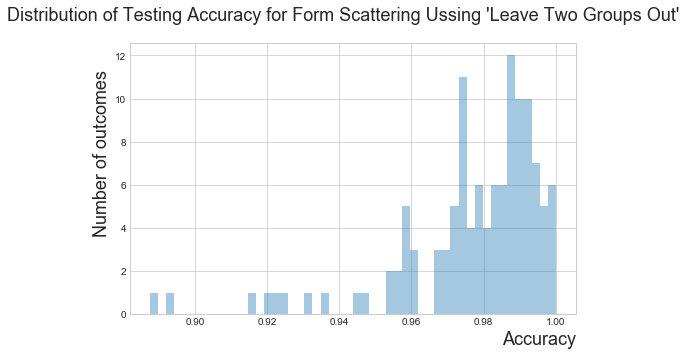

In [48]:
plt.figure(figsize=(8,5))
sns.distplot(test_scores_by_ex, kde=False, bins=50)
plt.suptitle("Distribution of Testing Accuracy for Form Scattering Ussing 'Leave Two Groups Out' ", fontsize=18)
plt.xlabel('Accuracy', fontsize=18,  horizontalalignment='right', x=1.0)
plt.ylabel('Number of outcomes', fontsize=18, horizontalalignment='right', y=0.9)

In [184]:
scaler = preprocessing.StandardScaler()
scaler.fit(train_good[features])
log = linear_model.SGDClassifier(alpha= 0.001,loss= 'log', l1_ratio= 0, penalty= 'none')

log.fit(scaler.transform(train_good[features]), train_good['form'])
hold_out_score = log.score(scaler.transform(test_good[features]), test_good['form'])
print("hold out score: ", hold_out_score)

hold out score:  0.994680851064


In [185]:
test_good['form_pred'] = log.predict(scaler.transform(test_good[features]))

pr = log.predict_proba(scaler.transform(test_good[features]))[ : , 1]
formated_pr = list(map(lambda x: "{0:.16f}".format(x), pr))

test_good['form_prob_true'] = pd.to_numeric(formated_pr)

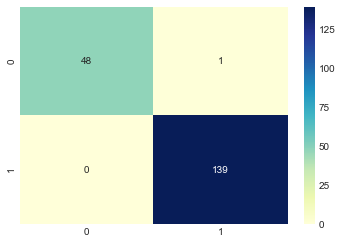

In [186]:
cnf_matrix = confusion_matrix(test_good['form'], test_good['form_pred'])
sns.heatmap(cnf_matrix, annot=True, fmt='.5g', cmap="YlGnBu")

**We have two false positive**

In [187]:
difference = test_good[test_good['form'] != test_good['form_pred']]
difference[['experiment','name', 'str_label','form','form_pred', 'form_prob_true']]

experiment                         name str_label   form  form_pred  \
462        R12  R12cooling2rd_0055_dz_bgsub  bad_data  False       True   

     form_prob_true  
462        0.999229

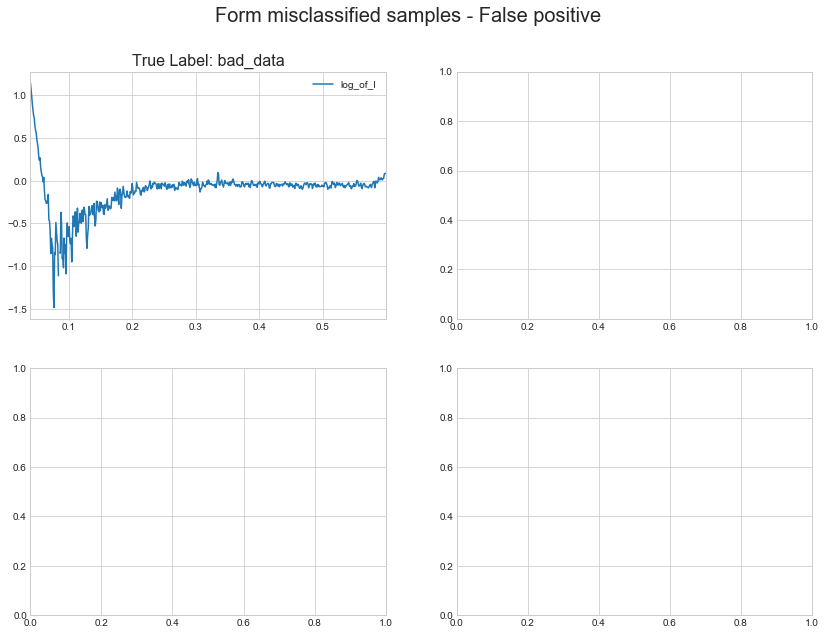

In [188]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(14,10))
st = fig.suptitle("Form misclassified samples - False positive", fontsize=20)
st.set_y(0.97)

for n in range(len(difference)): 
    d = difference.iloc[n]
    ex = d.iloc[0]
    file_name = d.iloc[1]
    str_label = difference.iloc[n]['str_label']
    df_v = pd.read_csv('../2016_saxs_data/' + ex + '/'+ file_name + '.csv')
    df_v['log_of_I'] = np.log10(df_v[' Intensity (counts)'])
    df_v.plot(x='# q (1/Angstrom)',y='log_of_I', ax=axes[n%2, n//2])
    axes[n%2, n//2].set_title('True Label: ' + str_label, fontsize=16);
    axes[n%2, n//2].xaxis.label.set_visible(False)

In [189]:
# to train the model on all avalible data 
all_data = train_good.append(hold_out[hold_out['bad_data']==False])
scaler = preprocessing.StandardScaler()
scaler.fit(all_data[features])
log = linear_model.SGDClassifier(alpha= 0.001,loss= 'log', l1_ratio= 0, penalty= 'none')
log.fit(scaler.transform(all_data[features]), all_data['form'])

# save the scaler and model
scalers['form_factor_scattering'] = scaler.__dict__
models['form_factor_scattering'] = log.__dict__

## Precursor Label

In [16]:
cv=LeavePGroupsOut(n_groups=2).split(train_good[features], train_good[['precursor']], groups=train_good['experiment'])

scaler = preprocessing.StandardScaler()
scaler.fit(train_good[features])
svc = linear_model.SGDClassifier(loss = 'log') # we want to use log regression only
clf = GridSearchCV(svc, parameters2, cv=cv)
    
clf.fit(scaler.transform(train_good[features]), train_good['precursor'])
print("Best parameters set found on training set:")
print(clf.best_params_)
    
print("Training score: ","%0.3f" %  clf.best_score_)#Cross-validated score on training set

Best parameters set found on training set:
{'alpha': 0.01, 'l1_ratio': 0.5, 'penalty': 'elasticnet'}
Training score:  0.779


In [49]:
test_scores_by_ex = []
training_score = []
stat_dic = {}
count = 0 # we have 120 combinations
for i in range(len(experiments)):
    for j in range(i +1, len(experiments)):
        print("Testing on: ", experiments[i], 'and', experiments[j])
        tr = train_good[(train_good['experiment']!= experiments[i]) & (train_good['experiment']!= experiments[j])]
        test = train_good[(train['experiment']== experiments[i]) | (train_good['experiment']== experiments[j])]
        
        scaler = preprocessing.StandardScaler()
        scaler.fit(tr[features])
        log = linear_model.SGDClassifier(alpha= 0.01,loss= 'log', l1_ratio= 0, penalty= 'l1')

        scores = cross_val_score(log, scaler.transform(tr[features]), tr['precursor'], cv=5)
        print("cross validation score: ", scores.mean())
        training_score.append(scores.mean())
       

        log.fit(scaler.transform(tr[features]), tr['precursor'])
        test_score = log.score(scaler.transform(test[features]), test['precursor'])
        print('test score: ', test_score)
        test_scores_by_ex.append(test_score)
        stat_dic[experiments[i]+ experiments[j]] = test_score
        count +=1
        print()
        
print("Average training score: ", sum(training_score)/count)
print("Average testing score: ", sum(test_scores_by_ex)/count)
print(count)

Testing on:  R1 and R12
cross validation score:  0.76793811126
test score:  0.845622119816

Testing on:  R1 and R13
cross validation score:  0.755601425601
test score:  0.947540983607

Testing on:  R1 and R2
cross validation score:  0.766836212462
test score:  0.857971014493

Testing on:  R1 and R3
cross validation score:  0.857793522267
test score:  0.714285714286

Testing on:  R1 and R4
cross validation score:  0.752012698413
test score:  0.933908045977

Testing on:  R1 and R5
cross validation score:  0.779030742004
test score:  0.857493857494

Testing on:  R1 and R6
cross validation score:  0.748818897638
test score:  0.917682926829

Testing on:  R1 and R7
cross validation score:  0.771587455076
test score:  0.892156862745

Testing on:  R1 and Reaction_A
cross validation score:  0.76517968518
test score:  0.930693069307

Testing on:  R1 and Reaction_B
cross validation score:  0.778625954198
test score:  0.890410958904

Testing on:  R1 and Reaction_C
cross validation score:  0.794331

test score:  0.88198757764

Testing on:  R6 and Reaction_B
cross validation score:  0.820188946623
test score:  0.8

Testing on:  R6 and Reaction_C
cross validation score:  0.806377875441
test score:  0.824561403509

Testing on:  R6 and Reaction_D
cross validation score:  0.806427766509
test score:  0.774193548387

Testing on:  R6 and Reaction_E
cross validation score:  0.8005272325
test score:  0.853146853147

Testing on:  R6 and Reaction_G
cross validation score:  0.803758909707
test score:  0.835820895522

Testing on:  R6 and Reaction_H
cross validation score:  0.802011356276
test score:  0.829931972789

Testing on:  R7 and Reaction_A
cross validation score:  0.796283136192
test score:  0.827338129496

Testing on:  R7 and Reaction_B
cross validation score:  0.808607639116
test score:  0.7578125

Testing on:  R7 and Reaction_C
cross validation score:  0.800392394678
test score:  0.664429530201

Testing on:  R7 and Reaction_D
cross validation score:  0.815464422363
test score:  0.6842

In [112]:
for w in sorted(stat_dic, key=stat_dic.get):
    print(w, stat_dic[w])

R3Reaction_G 0.388235294118
R3Reaction_D 0.392670157068
R3Reaction_B 0.403225806452
R3Reaction_H 0.426229508197
R3Reaction_E 0.430167597765
R3R7 0.485
R3Reaction_A 0.48730964467
R2R3 0.52719665272
R3Reaction_C 0.531400966184
R13R3 0.532663316583
R3R6 0.540540540541
Reaction_BReaction_G 0.540816326531
R3R5 0.558139534884
Reaction_CReaction_E 0.5625
Reaction_CReaction_H 0.598484848485
R3R4 0.599173553719
Reaction_BReaction_D 0.621848739496
R2Reaction_D 0.622093023256
Reaction_DReaction_G 0.631067961165
R12R3 0.640243902439
R2R7 0.640883977901
Reaction_CReaction_G 0.647058823529
R5Reaction_C 0.652
R12Reaction_C 0.660649819495
R2Reaction_G 0.662251655629
Reaction_DReaction_H 0.681034482759
Reaction_EReaction_H 0.682692307692
Reaction_AReaction_C 0.684931506849
R7Reaction_G 0.696428571429
Reaction_DReaction_E 0.696428571429
Reaction_EReaction_G 0.703296703297
R5Reaction_H 0.703539823009
R7Reaction_D 0.706766917293
R2Reaction_B 0.712574850299
R2Reaction_H 0.713414634146
R1R3 0.714285714286
R

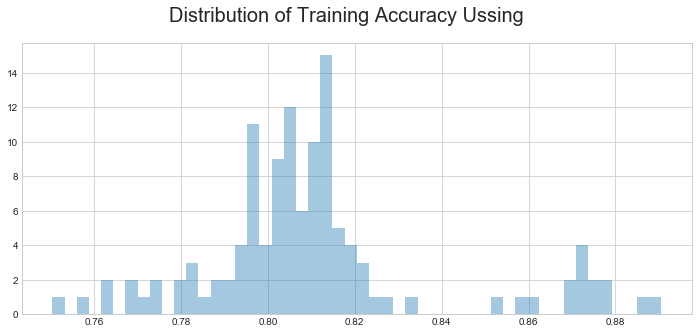

In [113]:
plt.figure(figsize=(12,5))
sns.distplot(training_score, kde=False, bins=50)
plt.suptitle("Distribution of Training Accuracy Ussing", fontsize=20)

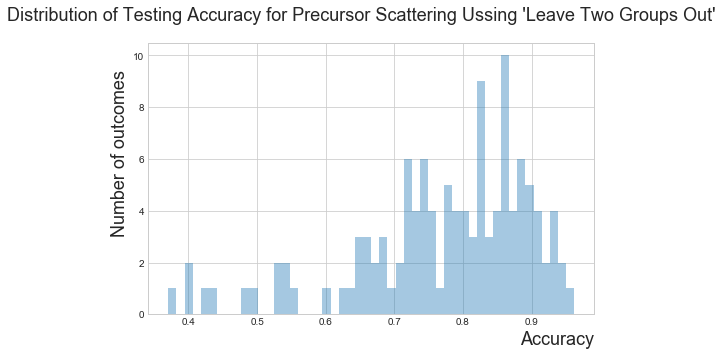

In [51]:
plt.figure(figsize=(8,5))
sns.distplot(test_scores_by_ex, kde=False, bins=50)
plt.suptitle("Distribution of Testing Accuracy for Precursor Scattering Ussing 'Leave Two Groups Out' ", fontsize=18)
plt.xlabel('Accuracy', fontsize=18,  horizontalalignment='right', x=1.0)
plt.ylabel('Number of outcomes', fontsize=18, horizontalalignment='right', y=0.9)

In [53]:
scaler = preprocessing.StandardScaler()
scaler.fit(train_good[features])
log = linear_model.SGDClassifier(alpha= 0.01,loss= 'log', l1_ratio= 0.95, penalty= 'l1')

log.fit(scaler.transform(train_good[features]), train_good['precursor'])
hold_out_score = log.score(scaler.transform(test_good[features]), test_good['precursor'])
print("hold out score: ", hold_out_score)

hold out score:  0.775401069519


In [54]:
test_good['precursor_pred'] = log.predict(scaler.transform(test_good[features]))

pr = log.predict_proba(scaler.transform(test_good[features]))[ : , 1]
formated_pr = list(map(lambda x: "{0:.16f}".format(x), pr))

test_good['precursor_prob_true'] = pd.to_numeric(formated_pr)

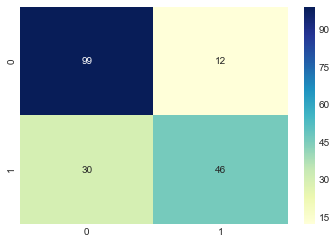

In [55]:
cnf_matrix = confusion_matrix(test_good['precursor'], test_good['precursor_pred'])
sns.heatmap(cnf_matrix, annot=True, fmt='.5g', cmap="YlGnBu")

**We have 32 false negative and 11 false positive**

In [197]:
difference = test_good[test_good['precursor'] != test_good['precursor_pred']]
difference[['experiment','name', 'str_label','precursor','precursor_pred', 'precursor_prob_true']].head()

experiment                                  name  \
865           R3                 R3_cool_0044_dz_bgsub   
1589  Reaction_B  B_240C_3min_0212155719_0001_dz_bgsub   
1910  Reaction_H       H_271C_0214203651_0001_dz_bgsub   
1100          R5             R5_1stcool2_0007_dz_bgsub   
1865  Reaction_G       G_273C_0214172046_0001_dz_bgsub   

                     str_label  precursor  precursor_pred  precursor_prob_true  
865   form_precursor_structure       True           False             0.186123  
1589  form_precursor_structure       True           False             0.465565  
1910           form_precursor_       True           False             0.482871  
1100            form_structure      False            True             0.655563  
1865  form_precursor_structure       True           False             0.155090

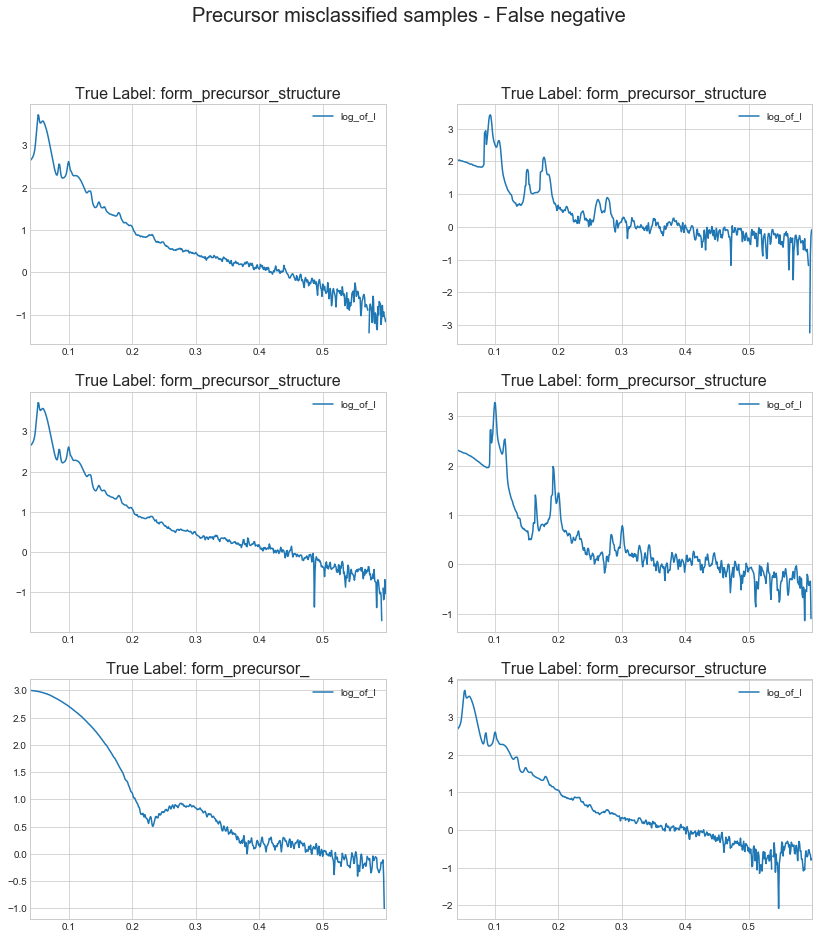

In [198]:
false_negative = difference[difference['precursor'] == True]

fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(14,15))
st = fig.suptitle("Precursor misclassified samples - False negative", fontsize=20)
st.set_y(0.97)

for n in range(6): 
    d = false_negative.iloc[n]
    ex = d.iloc[0]
    file_name = d.iloc[1]
    str_label = d.iloc[-7]
    df_v = pd.read_csv('../2016_saxs_data/' + ex + '/'+ file_name + '.csv')
    df_v['log_of_I'] = np.log10(df_v[' Intensity (counts)'])
    df_v.plot(x='# q (1/Angstrom)',y='log_of_I', ax=axes[n%3, n%2])
    #axes[n%2, n//2].set_title(file_name + " " + str_label);
    axes[n%3, n%2].set_title('True Label: ' + str_label, fontsize=16);
    axes[n%3, n%2].xaxis.label.set_visible(False)

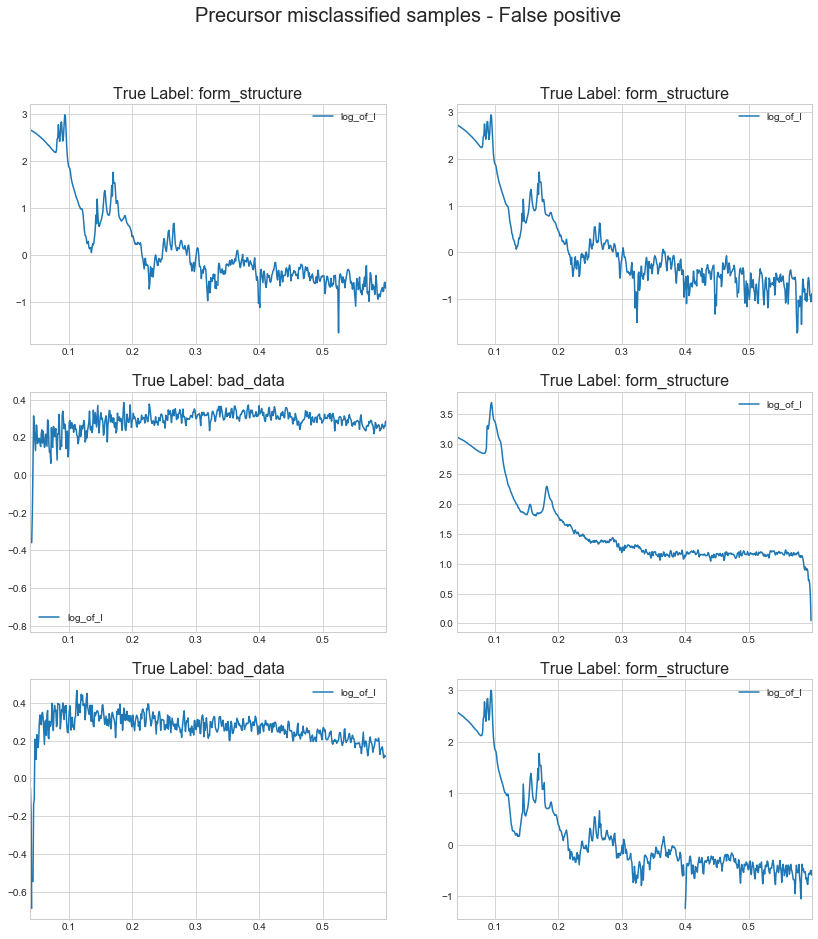

In [199]:
false_positive = difference[difference['precursor'] == False]

fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(14,15))
st = fig.suptitle("Precursor misclassified samples - False positive", fontsize=20)
st.set_y(0.97)

for n in range(6): 
    d = false_positive.iloc[n]
    ex = d.iloc[0]
    file_name = d.iloc[1]
    str_label = d.iloc[-7]
    df_v = pd.read_csv('../2016_saxs_data/' + ex + '/'+ file_name + '.csv')
    df_v['log_of_I'] = np.log10(df_v[' Intensity (counts)'])
    df_v.plot(x='# q (1/Angstrom)',y='log_of_I', ax=axes[n%3, n%2])
    #axes[n%2, n//2].set_title(file_name + " " + str_label);
    axes[n%3, n%2].set_title('True Label: ' + str_label, fontsize=16);
    axes[n%3, n%2].xaxis.label.set_visible(False)

In [63]:
# R3 is the most problematic
difference_R3 = test_good[(test_good['precursor'] != test_good['precursor_pred']) & (test_good['experiment'] == 'R3')]
difference_R3[['experiment','name', 'str_label','precursor','precursor_pred', 'precursor_prob_true']].head()

experiment                   name                 str_label  precursor  \
865         R3  R3_cool_0044_dz_bgsub  form_precursor_structure       True   
861         R3  R3_cool_0040_dz_bgsub  form_precursor_structure       True   
823         R3  R3_cool_0002_dz_bgsub  form_precursor_structure       True   
955         R3  R3_SAXS_0064_dz_bgsub  form_precursor_structure       True   
838         R3  R3_cool_0017_dz_bgsub  form_precursor_structure       True   

     precursor_pred  precursor_prob_true  
865           False             0.190355  
861           False             0.205823  
823           False             0.163579  
955           False             0.205854  
838           False             0.201163

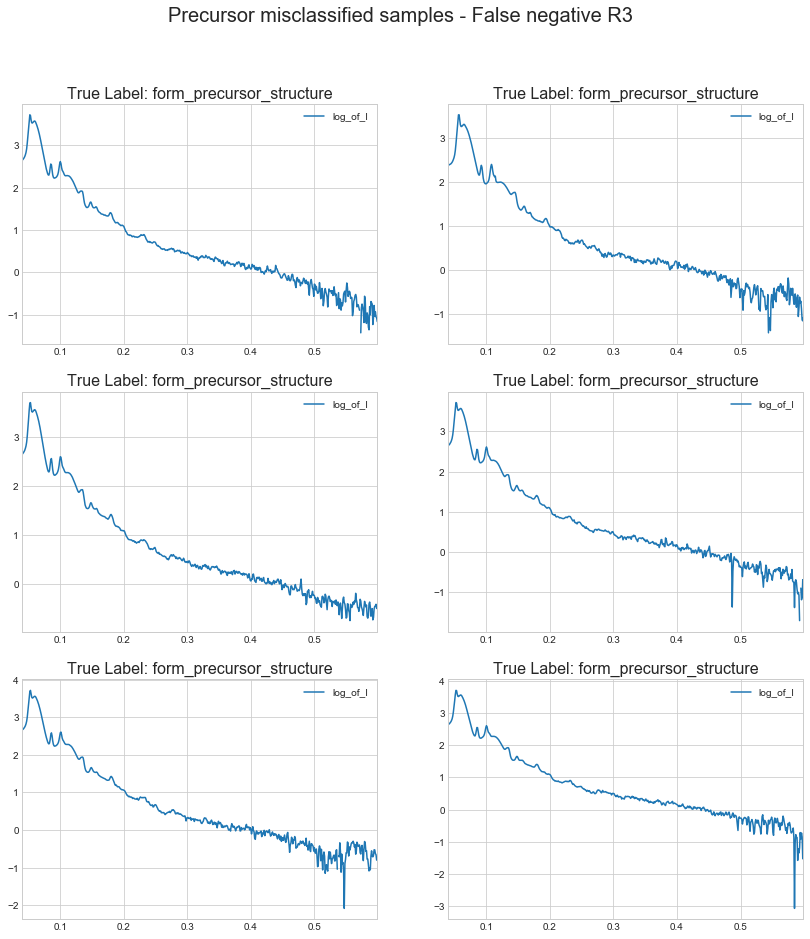

In [64]:
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(14,15))
st = fig.suptitle("Precursor misclassified samples - False negative R3", fontsize=20)
st.set_y(0.97)

for n in range(6): 
    d = difference_R3.iloc[n]
    ex = d.iloc[0]
    file_name = d.iloc[1]
    str_label = d['str_label']
    df_v = pd.read_csv('../2016_saxs_data/' + ex + '/'+ file_name + '.csv')
    df_v['log_of_I'] = np.log10(df_v[' Intensity (counts)'])
    df_v.plot(x='# q (1/Angstrom)',y='log_of_I', ax=axes[n%3, n%2])
    #axes[n%2, n//2].set_title(file_name + " " + str_label);
    axes[n%3, n%2].set_title('True Label: ' + str_label, fontsize=16);
    axes[n%3, n%2].xaxis.label.set_visible(False)

In [206]:
# to train the model on all avalible data 
all_data = train_good.append(hold_out[hold_out['bad_data']==False])
scaler = preprocessing.StandardScaler()
scaler.fit(all_data[features])
log = linear_model.SGDClassifier(alpha= 0.01,loss= 'log', l1_ratio= 0.95, penalty= 'l1')
log.fit(scaler.transform(all_data[features]), all_data['precursor'])

# save the scaler and model
scalers['precursor_scattering'] = scaler.__dict__
models['precursor_scattering'] = log.__dict__

## Structure Label

In [143]:
cv=LeavePGroupsOut(n_groups=2).split(train_good[features], train_good[['structure']], groups=train_good['experiment'])

scaler = preprocessing.StandardScaler()
scaler.fit(train_good[features])
svc = linear_model.SGDClassifier(loss = 'log') # we want to use log regression only
clf = GridSearchCV(svc, parameters2, cv=cv)
    
clf.fit(scaler.transform(train_good[features]), train_good['structure'])
print("Best parameters set found on training set:")
print(clf.best_params_)
    
print("Training score: ","%0.3f" %  clf.best_score_)#Cross-validated score on training set

Best parameters set found on training set:
{'alpha': 0.001, 'l1_ratio': 0, 'penalty': 'l1'}
Training score:  0.969


In [65]:
test_scores_by_ex = []
training_score = []
stat_dic = {}
count = 0 # we have 120 combinations
for i in range(len(experiments)):
    for j in range(i +1, len(experiments)):
        print("Testing on: ", experiments[i], 'and', experiments[j])
        tr = train_good[(train_good['experiment']!= experiments[i]) & (train_good['experiment']!= experiments[j])]
        test = train_good[(train['experiment']== experiments[i]) | (train_good['experiment']== experiments[j])]
        
        scaler = preprocessing.StandardScaler()
        scaler.fit(tr[features])
        log = linear_model.SGDClassifier(alpha= 0.001,loss= 'log', l1_ratio= 0, penalty= 'l1')

        scores = cross_val_score(log, scaler.transform(tr[features]), tr['structure'], cv=5)
        print("cross validation score: ", scores.mean())
        training_score.append(scores.mean())

        log.fit(scaler.transform(tr[features]), tr['structure'])
        test_score = log.score(scaler.transform(test[features]), test['structure'])
        print('test score: ', test_score)
        test_scores_by_ex.append(test_score)
        stat_dic[experiments[i]+ experiments[j]] = test_score
        count +=1
        print()
        
print("Average training score: ", sum(training_score)/count)
print("Average testing score: ", sum(test_scores_by_ex)/count)

Testing on:  R1 and R12
cross validation score:  0.975158557896
test score:  0.960829493088

Testing on:  R1 and R13
cross validation score:  0.971490849398
test score:  0.950819672131

Testing on:  R1 and R2
cross validation score:  0.972158983115
test score:  0.959420289855

Testing on:  R1 and R3
cross validation score:  0.970915344806
test score:  0.96978021978

Testing on:  R1 and R4
cross validation score:  0.971305179283
test score:  0.968390804598

Testing on:  R1 and R5
cross validation score:  0.987440490841
test score:  0.921375921376

Testing on:  R1 and R6
cross validation score:  0.970964808167
test score:  0.966463414634

Testing on:  R1 and R7
cross validation score:  0.97300258091
test score:  0.960784313725

Testing on:  R1 and Reaction_A
cross validation score:  0.971517330138
test score:  0.96699669967

Testing on:  R1 and Reaction_B
cross validation score:  0.973296732858
test score:  0.962328767123

Testing on:  R1 and Reaction_C
cross validation score:  0.9720809

cross validation score:  0.967149923247
test score:  0.994152046784

Testing on:  R6 and Reaction_D
cross validation score:  0.966820057313
test score:  0.993548387097

Testing on:  R6 and Reaction_E
cross validation score:  0.969156786279
test score:  0.993006993007

Testing on:  R6 and Reaction_G
cross validation score:  0.967309663591
test score:  0.985074626866

Testing on:  R6 and Reaction_H
cross validation score:  0.968387119814
test score:  0.993197278912

Testing on:  R7 and Reaction_A
cross validation score:  0.967873673384
test score:  0.978417266187

Testing on:  R7 and Reaction_B
cross validation score:  0.967429845965
test score:  0.9765625

Testing on:  R7 and Reaction_C
cross validation score:  0.967650195521
test score:  0.986577181208

Testing on:  R7 and Reaction_D
cross validation score:  0.967328364793
test score:  0.984962406015

Testing on:  R7 and Reaction_E
cross validation score:  0.968934843935
test score:  0.97520661157

Testing on:  R7 and Reaction_G
cross 

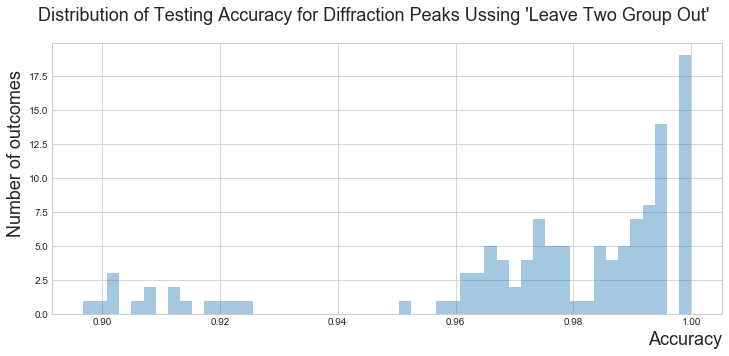

In [70]:
plt.figure(figsize=(12,5))
sns.distplot(test_scores_by_ex, kde=False, bins=50)
plt.suptitle("Distribution of Testing Accuracy for Diffraction Peaks Ussing 'Leave Two Group Out' ", fontsize=18)
plt.xlabel('Accuracy', fontsize=18,  horizontalalignment='right', x=1.0)
plt.ylabel('Number of outcomes', fontsize=18, horizontalalignment='right', y=0.9)

In [69]:
for w in sorted(stat_dic, key=stat_dic.get):
    print(w, stat_dic[w])

R5Reaction_G 0.896713615023
R5Reaction_B 0.899563318777
R5Reaction_E 0.900900900901
R5R7 0.901234567901
R5Reaction_H 0.902654867257
R5Reaction_D 0.905982905983
R5Reaction_A 0.908333333333
R13R5 0.909090909091
R5Reaction_C 0.912
R5R6 0.91320754717
R2R5 0.914893617021
R4R5 0.919298245614
R1R5 0.921375921376
R12R5 0.921832884097
R3R5 0.923588039867
R1R13 0.950819672131
R2Reaction_H 0.957317073171
R1R2 0.959420289855
R1R7 0.960784313725
R1R12 0.960829493088
R1Reaction_B 0.962328767123
R12R7 0.962962962963
R1Reaction_G 0.963768115942
R12R2 0.964401294498
R1Reaction_E 0.964912280702
R2Reaction_D 0.96511627907
R1Reaction_H 0.965397923875
R1Reaction_D 0.96632996633
R1R6 0.966463414634
R1Reaction_A 0.96699669967
R1Reaction_C 0.968051118211
R1R4 0.968390804598
R12Reaction_B 0.96875
R1R3 0.96978021978
R12Reaction_G 0.970833333333
R12Reaction_E 0.971887550201
R2Reaction_A 0.97191011236
R12Reaction_H 0.97233201581
R12R6 0.972602739726
R12Reaction_D 0.973180076628
R7Reaction_G 0.973214285714
R12Reac

In [71]:
scaler = preprocessing.StandardScaler()
scaler.fit(train_good[features])
log = linear_model.SGDClassifier(alpha= 0.001,loss= 'log', l1_ratio= 0, penalty= 'l1')

log.fit(scaler.transform(train_good[features]), train_good['structure'])
hold_out_score = log.score(scaler.transform(test_good[features]), test_good['structure'])
print("hold out score: ", hold_out_score)

hold out score:  0.994652406417


In [147]:
scalers['diffraction_peaks'] = scaler
models['diffraction_peaks'] = log

In [72]:
test_good['structure_pred'] = log.predict(scaler.transform(test_good[features]))

pr = log.predict_proba(scaler.transform(test_good[features]))[ : , 1]
formated_pr = list(map(lambda x: "{0:.16f}".format(x), pr))

test_good['structure_prob_true'] = pd.to_numeric(formated_pr)

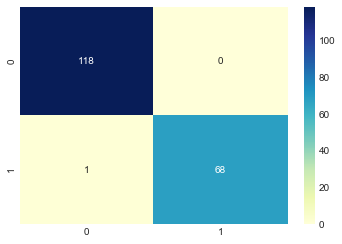

In [150]:
cnf_matrix = confusion_matrix(test_good['structure'], test_good['structure_pred'])
sns.heatmap(cnf_matrix, annot=True, fmt='.5g', cmap="YlGnBu")

In [75]:
difference = test_good[test_good['structure'] != test_good['structure_pred']]
difference.head()

experiment                              name  q_Imax  Imax_over_Imean  \
559        R12  R12cooling_heating_0044_dz_bgsub    0.04        15.518557   

     Imax_sharpness  logI_fluctuation  logI_max_over_std  bad_data  form  \
559        1.026437          5.450571           2.865114     False  True   

     precursor  structure       str_label  bad_data_pred  bad_data_prob_true  \
559      False       True  form_structure          False                 0.0   

     precursor_pred  precursor_prob_true  structure_pred  structure_prob_true  
559           False             0.282011           False             0.030757

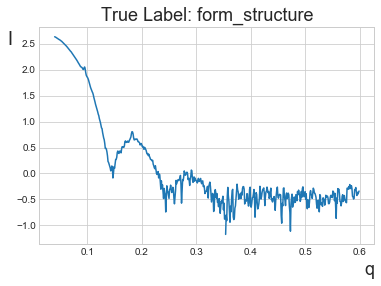

In [80]:
df_v = pd.read_csv('../2016_saxs_data/R12/R12cooling_heating_0044_dz_bgsub.csv')
df_v['log_of_I'] = np.log10(df_v[' Intensity (counts)'])

sns.set_style('whitegrid')
fig,ax = plt.subplots(1)
ax.plot(df_v['# q (1/Angstrom)'], df_v['log_of_I'])
plt.xlabel('q', fontsize=18,  horizontalalignment='right', x=1.0)
plt.ylabel('I', fontsize=18, horizontalalignment='right', y=0.9, rotation=0)
plt.title('True Label: form_structure' , fontsize=18)

We have 1 false negative.

In [207]:
# to train the model on all avalible data 
all_data = train_good.append(hold_out[hold_out['bad_data']==False])
scaler = preprocessing.StandardScaler()
scaler.fit(all_data[features])
log = linear_model.SGDClassifier(alpha= 0.001,loss= 'log', l1_ratio= 0, penalty= 'l1')
log.fit(scaler.transform(all_data[features]), all_data['structure'])

# save the scaler and model
scalers['diffraction_peaks'] = scaler.__dict__
models['diffraction_peaks'] = log.__dict__

In [208]:
with open('scalers_and_models.yml', 'w') as yaml_file:
    yaml.dump(scalers_and_models, yaml_file)

In [209]:
with open('scalers_and_models.yml') as info:
      s_and_m = yaml.load(info)

In [210]:
s_and_m

{'models': {'bad_data': {'C': 1.0,
   '_expanded_class_weight': array([ 1.,  1.]),
   'alpha': 0.001,
   'average': False,
   'class_weight': None,
   'classes_': array([False,  True], dtype=bool),
   'coef_': array([[ 1.64268707, -7.82259498,  3.61217901,  1.06955799,  0.        ]]),
   'epsilon': 0.1,
   'eta0': 0.0,
   'fit_intercept': True,
   'intercept_': array([-9.21916533]),
   'l1_ratio': 0.95,
   'learning_rate': 'optimal',
   'loss': 'log',
   'loss_function_': <sklearn.linear_model.sgd_fast.Log at 0x1a2317b648>,
   'max_iter': 5,
   'n_iter_': 5,
   'n_jobs': 1,
   'penalty': 'elasticnet',
   'power_t': 0.5,
   'random_state': None,
   'shuffle': True,
   't_': 9731.0,
   'tol': None,
   'verbose': 0,
   'warm_start': False},
  'diffraction_peaks': {'C': 1.0,
   '_expanded_class_weight': array([ 1.,  1.]),
   'alpha': 0.001,
   'average': False,
   'class_weight': None,
   'classes_': array([False,  True], dtype=bool),
   'coef_': array([[ 0.        ,  7.13876993,  8.973443

In [212]:
s_and_m['models']['bad_data']

{'C': 1.0,
 '_expanded_class_weight': array([ 1.,  1.]),
 'alpha': 0.001,
 'average': False,
 'class_weight': None,
 'classes_': array([False,  True], dtype=bool),
 'coef_': array([[ 1.64268707, -7.82259498,  3.61217901,  1.06955799,  0.        ]]),
 'epsilon': 0.1,
 'eta0': 0.0,
 'fit_intercept': True,
 'intercept_': array([-9.21916533]),
 'l1_ratio': 0.95,
 'learning_rate': 'optimal',
 'loss': 'log',
 'loss_function_': <sklearn.linear_model.sgd_fast.Log at 0x1a2317b648>,
 'max_iter': 5,
 'n_iter_': 5,
 'n_jobs': 1,
 'penalty': 'elasticnet',
 'power_t': 0.5,
 'random_state': None,
 'shuffle': True,
 't_': 9731.0,
 'tol': None,
 'verbose': 0,
 'warm_start': False}

## Results

### Supervised Learning using Logistic Regression  

|            | Average accuracy using “Leave two groups out”| Range of accuracy for  “Leave two groups out” | Accuracy on “holdout” set
| ------------- | ------------- 
| bad_data  | 0.973| 0.860 - 1.0 | 0.960
| Form Factor Scattering  |  0.975 | 0.865 - 1.0 | 0.994 
| Precursor Scattering | 0.765  | 0.388 - 0.962 | 0.766 
| Difraction Peaks | 0.975 | 0.895 - 1.0 | 0.994 

We got very large variance of accuracy for precursor (forom 0.388 to 0.962). I think, it is possible to find a better model for the "precursor" label. 